# Introduction
The focus of this project is to develop a Proof of Concept (POC) for a risk evaluation service tailored for retail banks. The objective is to apply machine learning to predict loan repayment behavior, categorizing borrowers into early, on-time, and late payers.

Using a dataset from Home Credit Group, the goal is to create multiple models that can identify statistical patterns in repayment behavior. These models will assist banks in making more informed, data-driven decisions about customer risk profiles.

The benefits of this POC include:

- **Improved Risk Management:** Early identification of high-risk loans, allowing for better loan approval strategies.
- **Borrower Segmentation:** Accurately categorizing borrowers based on repayment behavior, which can inform loan portfolio strategies.
- **Marketing Opportunities:** Predictive insights could help banks tailor different repayment terms or tariffs, maximizing revenue from higher-risk borrowers just as an example (though banks need to weigh the potential ethical implications of such practices).


# Objectives
- Develop a feature that captures and summarizes repayment behavior based on relevant financial and demographic data.
- Build models to predict the probability of repayment behavior (early, on-time, late), improving prediction quality through careful data refinement that increases accuracy and/or robustness.

# Libary and data import

In [1]:
# Essential libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math
import re
from IPython.display import display

# Statistical methods
from scipy.stats import pearsonr, f_oneway

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

# Modelling
import optuna
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.base import RegressorMixin, BaseEstimator

# Resampling for imbalanced data
from imblearn.over_sampling import SMOTE

# SHAP for model interpretability
import shap

from functions import *

# Suppress warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)


In [2]:
application_train = pd.read_csv('data/application_train.csv')
application_test = pd.read_csv('data/application_test.csv')
installments_payments = pd.read_csv('data/installments_payments.csv')
print("application_train shape:", application_train.shape)
print("application_test shape:", application_test.shape)
print("installments_payments shape:", installments_payments.shape)

application_train shape: (307511, 122)
application_test shape: (48744, 121)
installments_payments shape: (13605401, 8)


It is apparent that `application_train` and `application_test` have same features, except target feature is missing in the training set. This target feature was from original exercise and will not be used in this project. Hence, we can drop it from the training set and combine training and testing sets in order to have more data for the model.

In [3]:
application_train = application_train.drop(columns=['TARGET'])
application = pd.concat([application_train, application_test], ignore_index=True)
print("Combined application dataframe shape:", application.shape)

Combined application dataframe shape: (356255, 121)


Since `installment_payments` will be used to create the target feature, must make sure it's not missing any values in key columns.

In [4]:
missing_data = installments_payments[['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']].isnull().sum()

print("Missing values in key columns:")
print(missing_data)

Missing values in key columns:
DAYS_INSTALMENT          0
DAYS_ENTRY_PAYMENT    2905
AMT_INSTALMENT           0
AMT_PAYMENT           2905
dtype: int64


It appears that there are some missing values. However, it's only missing values in columns which supposed to hold value of day when repayment was made and and the amount. This suggests that repayments were not made in these instances which is valuable information.

## Target feature creation and distribution
Based on when payments were supposed to be made and were actually made we can create a new feature which indicates whether repayments was early, on time or late.
And we also need to check the distribution of the target feature.

In [5]:
installments_payments['TARGET_REPAYMENT'] = np.where(
    installments_payments['DAYS_ENTRY_PAYMENT'].isnull(), 'late',
    np.where(installments_payments['DAYS_ENTRY_PAYMENT'] < installments_payments['DAYS_INSTALMENT'], 'early',
    np.where(installments_payments['DAYS_ENTRY_PAYMENT'] == installments_payments['DAYS_INSTALMENT'], 'on_time', 'late'))
)

value_counts = installments_payments['TARGET_REPAYMENT'].value_counts()
percentages = (value_counts / value_counts.sum()) * 100

for category, count in value_counts.items():
    percentage = percentages[category]
    print(f"{category} {count} ({percentage:.2f}%)")

early 9309477 (68.42%)
on_time 3146350 (23.13%)
late 1149574 (8.45%)


Feature was successfully engineered, however, the distribution is not balanced which will be a problem for the future model.

And now, the final step of feature engineering, `installments_payments` will be grouped by `SK_ID_CURR` to create early/on_time/late distribution for each customer.b

In [6]:
repayment_behavior = installments_payments.groupby('SK_ID_CURR')['TARGET_REPAYMENT'].value_counts(normalize=True).unstack().fillna(0)
print('Length: ', len(repayment_behavior))
print(repayment_behavior.head())

Length:  339587
TARGET_REPAYMENT     early      late   on_time
SK_ID_CURR                                    
100001            0.571429  0.142857  0.285714
100002            1.000000  0.000000  0.000000
100003            1.000000  0.000000  0.000000
100004            1.000000  0.000000  0.000000
100005            0.888889  0.111111  0.000000


Left-joining repayment behavior distributions to the main dataset.

In [7]:
application = application.merge(repayment_behavior, on='SK_ID_CURR', how='left')
print(application[['SK_ID_CURR', 'early', 'on_time', 'late']].head())

   SK_ID_CURR     early   on_time      late
0      100002  1.000000  0.000000  0.000000
1      100003  1.000000  0.000000  0.000000
2      100004  1.000000  0.000000  0.000000
3      100006  1.000000  0.000000  0.000000
4      100007  0.621212  0.136364  0.242424


The operation was successful. Now let's visualize how many customers have repayment behavior data vs those who don't.

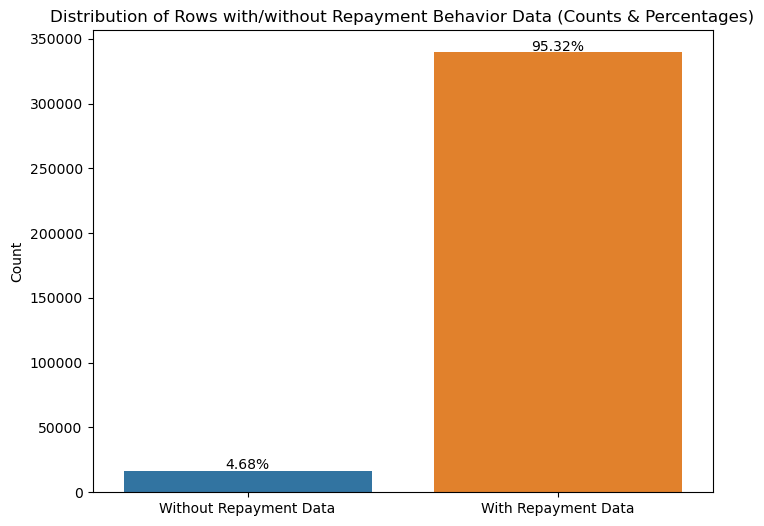

In [8]:
application['has_repayment_data'] = (~application[['early', 'on_time', 'late']].isnull().all(axis=1)).astype(int)

lookup_counts = application['has_repayment_data'].value_counts()
lookup_percentages = application['has_repayment_data'].value_counts(normalize=True) * 100

lookup_summary = pd.DataFrame({
    'Count': lookup_counts,
    'Percentage': lookup_percentages
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=['Without Repayment Data', 'With Repayment Data'], y=lookup_summary['Count'].values[::-1])

for i, val in enumerate(lookup_summary['Percentage'][::-1]):
    ax.text(i, lookup_summary['Count'].values[::-1][i] + 1000, f'{val:.2f}%', ha='center')

plt.ylabel('Count')
plt.title('Distribution of Rows with/without Repayment Behavior Data (Counts & Percentages)')
plt.show()

Less than 5% of the customers do not have historical repayment behavior data. This data will be dropped since target is non-existent making it useless for ML training and prediction validation.

In [9]:
application = application[application['has_repayment_data'] == 1]
application = application.drop(columns=['has_repayment_data'])
print("Updated application dataframe shape:", application.shape)

Updated application dataframe shape: (339587, 124)


Since now we have our tables ready, let's investigate the missing values.

In [10]:
missing_summary_application = []

for column in application.columns:
    missing_count = application[column].isnull().sum()
    missing_percentage = (missing_count / application.shape[0]) * 100
    missing_summary_application.append({
        'Column': column,
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_percentage
    })

missing_summary_application_df = pd.DataFrame(missing_summary_application)
missing_summary_application_sorted = missing_summary_application_df[missing_summary_application_df['Missing_Count'] > 0].sort_values(by='Missing_Percentage', ascending=False)
print(missing_summary_application_sorted.to_string(index=False))


                      Column  Missing_Count  Missing_Percentage
             COMMONAREA_MEDI         237956           70.072176
             COMMONAREA_MODE         237956           70.072176
              COMMONAREA_AVG         237956           70.072176
    NONLIVINGAPARTMENTS_MODE         236573           69.664917
     NONLIVINGAPARTMENTS_AVG         236573           69.664917
    NONLIVINGAPARTMENTS_MEDI         236573           69.664917
          FONDKAPREMONT_MODE         232990           68.609811
       LIVINGAPARTMENTS_MEDI         232886           68.579186
        LIVINGAPARTMENTS_AVG         232886           68.579186
       LIVINGAPARTMENTS_MODE         232886           68.579186
              FLOORSMIN_MEDI         231104           68.054431
               FLOORSMIN_AVG         231104           68.054431
              FLOORSMIN_MODE         231104           68.054431
             YEARS_BUILD_AVG         226602           66.728703
            YEARS_BUILD_MEDI         226

Appears that significant portion of features have missing values ranging from as low as <1% to over 70%. This is not ideal for modelling, however before imputation we will first attempt training models that can deal with missing values and try to iteratively improve these models by imputing missing features later on.

# EDA and data cleaning
As a first step of data cleaning let's assure there are no white spaces or special characters in column names since some models cannot work with such feature names.

In [11]:
application = clean_column_names(application)

And now let's check how features correlate with our three targets.

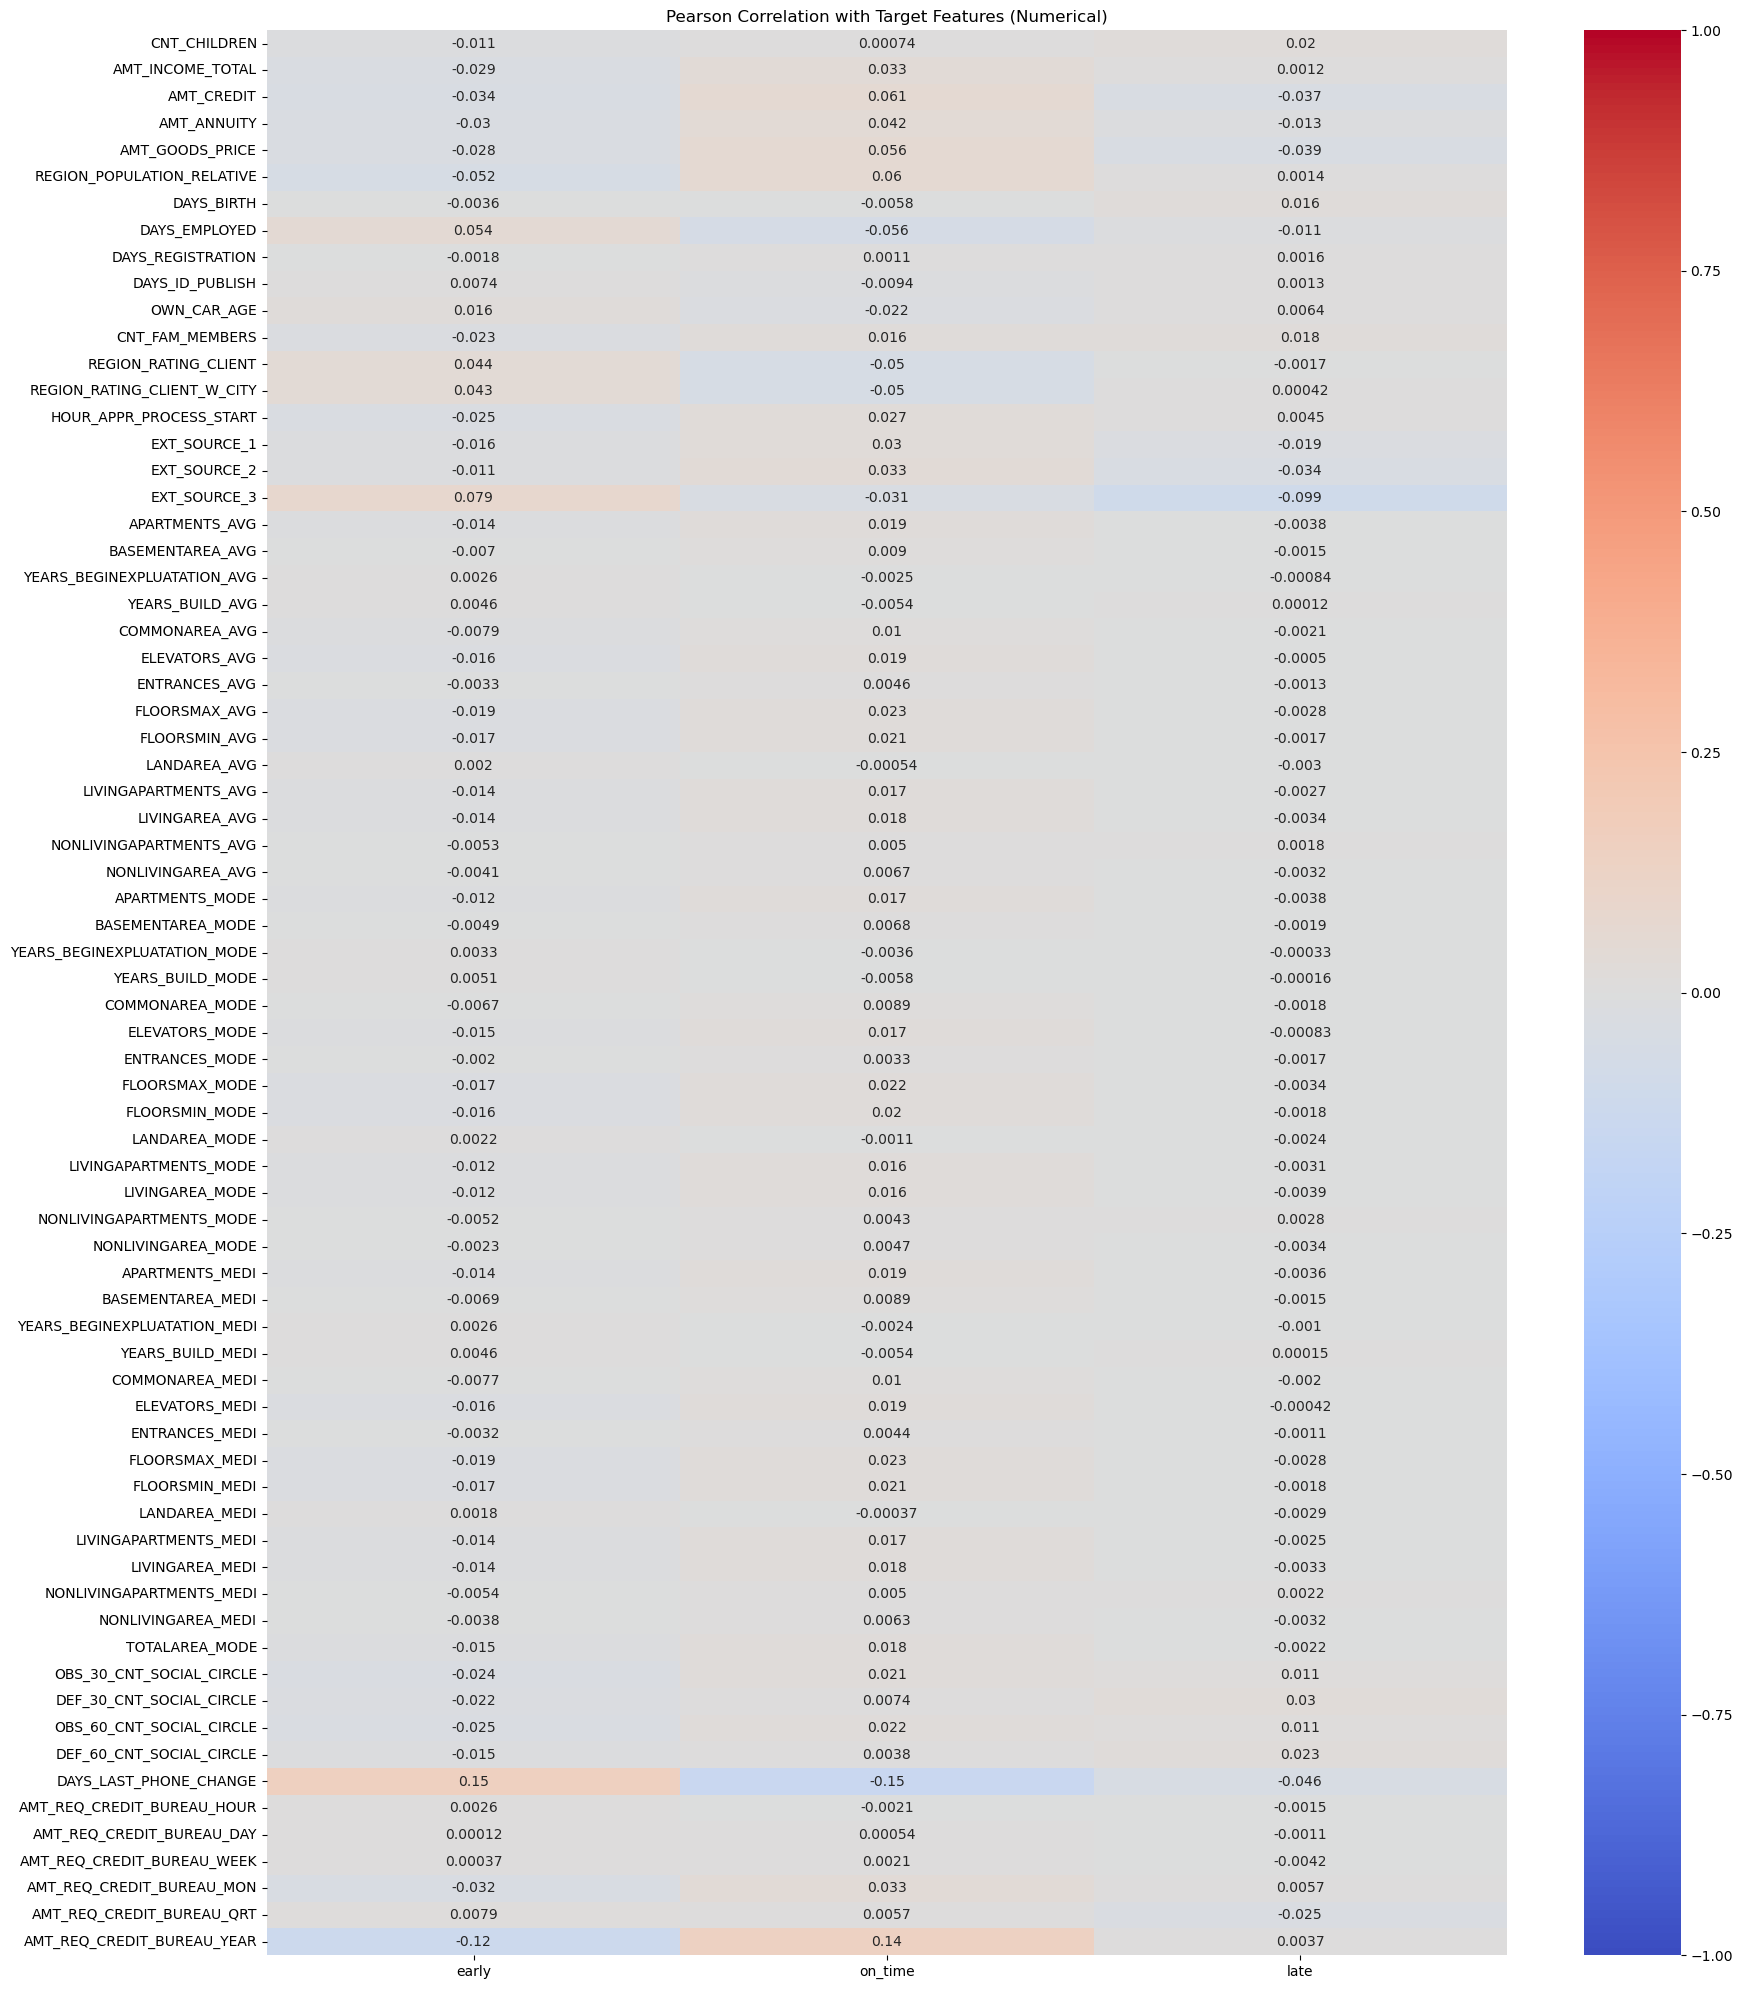

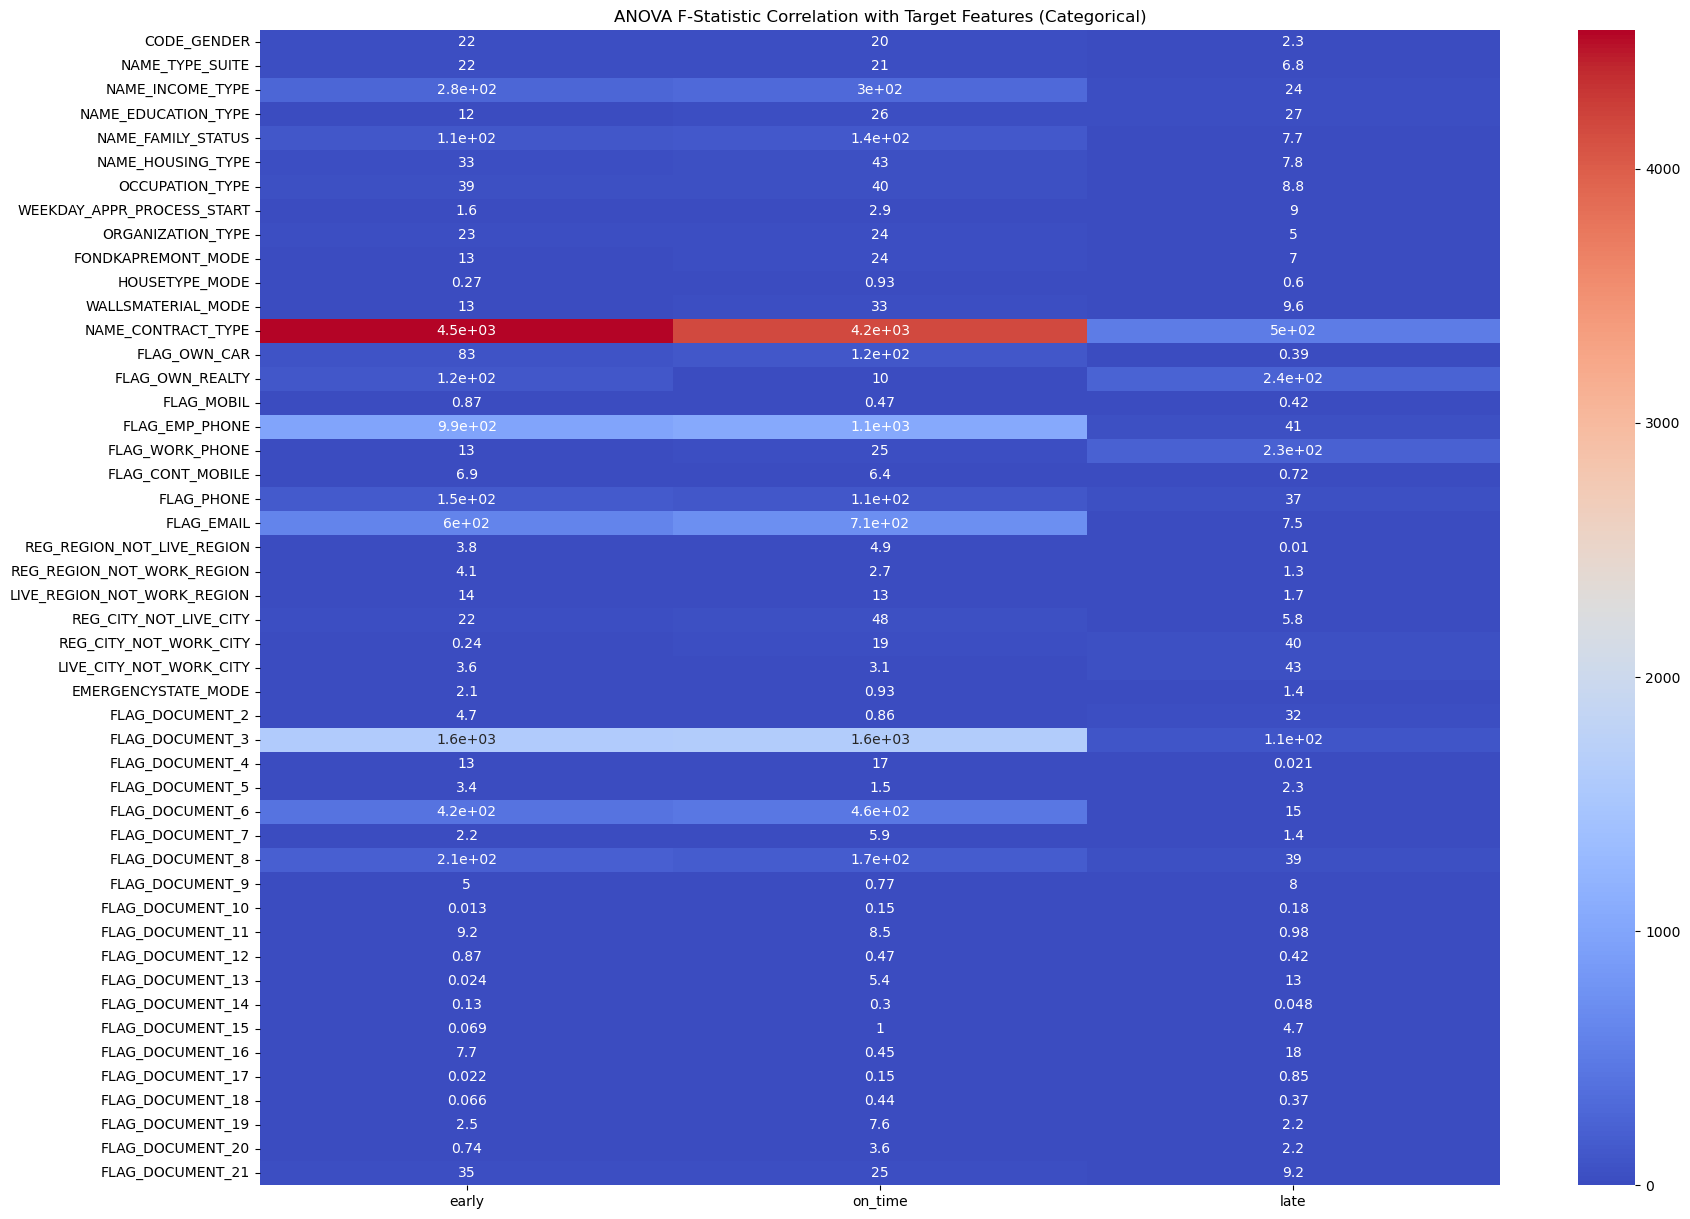

In [12]:
temp_data = application.copy()
temp_data = temp_data.drop(columns=['SK_ID_CURR'])

temp_data.fillna({
    col: temp_data[col].mean() if temp_data[col].dtype in [np.float64, np.int64] else temp_data[col].mode()[0]
    for col in temp_data.columns
}, inplace=True)

binary_columns = [col for col in temp_data.columns if temp_data[col].nunique() == 2 and col not in ['early', 'on_time', 'late']]
numerical_features = [col for col in temp_data.select_dtypes(include=[np.number]).columns if col not in binary_columns and col not in ['early', 'on_time', 'late']]
categorical_features = [col for col in temp_data.columns if col not in numerical_features and col not in binary_columns and col not in ['early', 'on_time', 'late']]

pearson_correlations = {'early': {}, 'on_time': {}, 'late': {}}
anova_results = {'early': {}, 'on_time': {}, 'late': {}}

for col in numerical_features:
    pearson_correlations['early'][col], _ = pearsonr(temp_data['early'], temp_data[col])
    pearson_correlations['on_time'][col], _ = pearsonr(temp_data['on_time'], temp_data[col])
    pearson_correlations['late'][col], _ = pearsonr(temp_data['late'], temp_data[col])

for col in categorical_features + binary_columns:
    anova_early = f_oneway(*[group['early'].values for name, group in temp_data.groupby(col)])
    anova_on_time = f_oneway(*[group['on_time'].values for name, group in temp_data.groupby(col)])
    anova_late = f_oneway(*[group['late'].values for name, group in temp_data.groupby(col)])
    
    anova_results['early'][col] = anova_early.statistic
    anova_results['on_time'][col] = anova_on_time.statistic
    anova_results['late'][col] = anova_late.statistic

pearson_df = pd.DataFrame(pearson_correlations).fillna(0)
anova_df = pd.DataFrame(anova_results).fillna(0)

plt.figure(figsize=(20, 25))
sns.heatmap(pearson_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation with Target Features (Numerical)')
plt.show()

plt.figure(figsize=(20, 15))
sns.heatmap(anova_df, annot=True, cmap='coolwarm', vmin=0)
plt.title('ANOVA F-Statistic Correlation with Target Features (Categorical)')
plt.show()


- Overall, numerical features show weak linear correlations with the target features.
- `DAYS_LAST_PHONE_CHANGE` show somewhat significant correlation indicating that customers who change their phone number less frequently are more likely to repay early.
- `EXT_SOURCE_*` show relatively significant correlations. However, it's not disclosed what these features actually mean.
- `NAME_CONTRACT_TYPE` show very high F-statistic values, particulary for `early` and `on_time` suggesting that contract type is a significant factor in determining repayment behavior.
- Ownership flags like `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` have moderate F-statistic values for `early`.
- `ORGANIZATION_TYPE`, `NAME_INCOME_TYPE`, `NAME_HOUSING_TYPE`, and `OCCUPATION_TYPE` show moderate F-statistic values, suggesting that these features might influence repayment patterns.

Outliers and anomalies can severely impact models performance. We will investigate outliers using IQR method and print out most extreme values in search for anomalies.

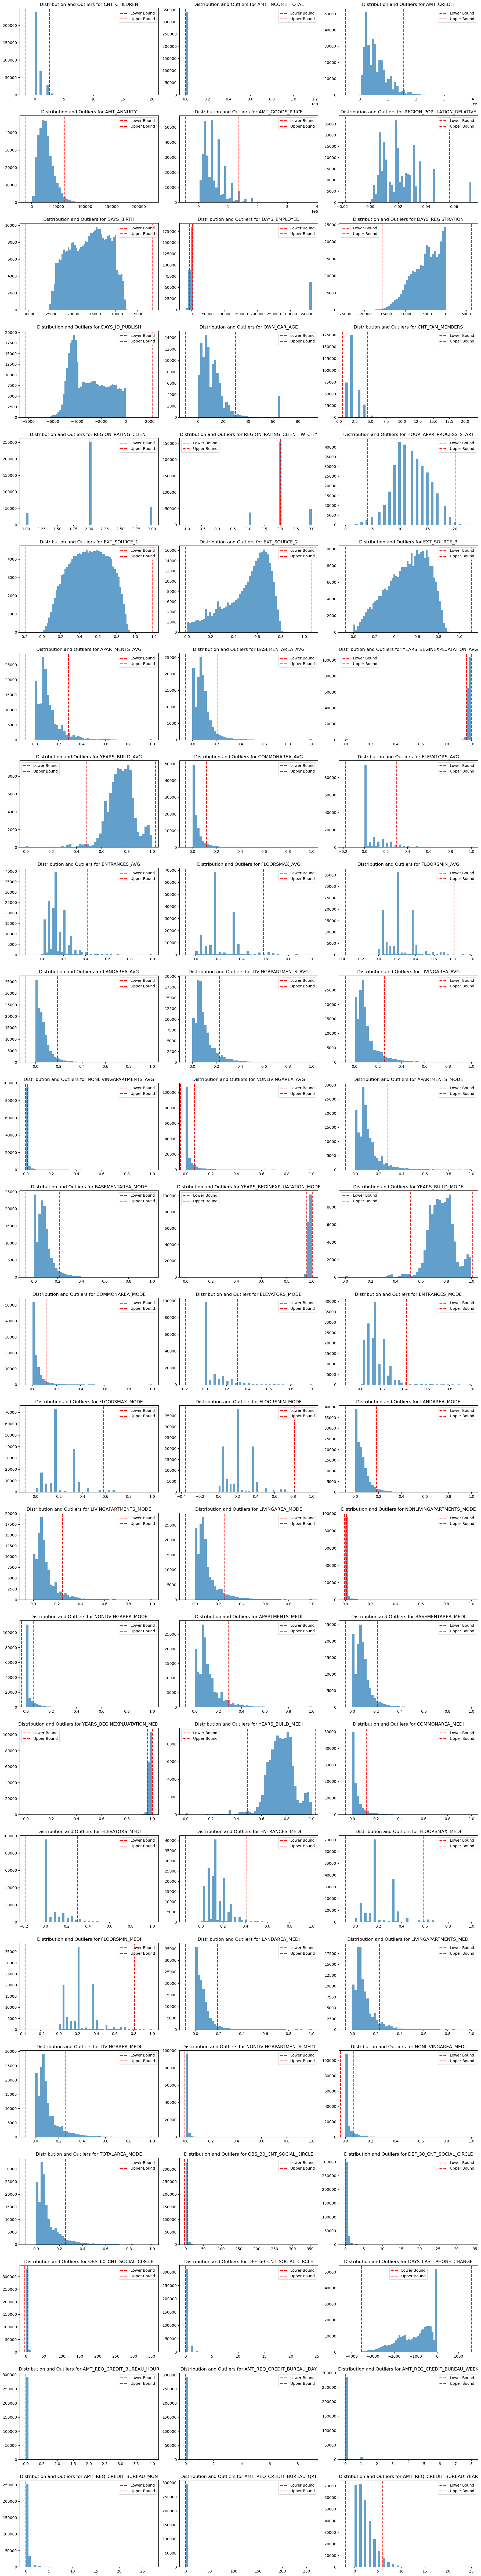

Anomaly Detection Results:

Anomalies detected in CNT_CHILDREN:
Lower bound: -1.5, Upper bound: 2.5
Most extreme values for CNT_CHILDREN:
         CNT_CHILDREN  SK_ID_CURR
91                 3      100108
222959             3      358251
223139             3      358455
Most extreme values for CNT_CHILDREN:
         CNT_CHILDREN  SK_ID_CURR
155369            19      280108
265784            19      407877
325150            20      227945

Anomalies detected in AMT_INCOME_TOTAL:
Lower bound: -22500.0, Upper bound: 337500.0
Most extreme values for AMT_INCOME_TOTAL:
         AMT_INCOME_TOTAL  SK_ID_CURR
229975          337545.0      366373
269744          338400.0      412614
18247           338746.5      121286
Most extreme values for AMT_INCOME_TOTAL:
         AMT_INCOME_TOTAL  SK_ID_CURR
246858        13500000.0      385674
203693        18000090.0      336147
12840        117000000.0      114967

Anomalies detected in AMT_CREDIT:
Lower bound: -505696.5, Upper bound: 1562827.5
Most ext

In [13]:
binary_columns = [col for col in application.columns if application[col].nunique() == 2]
categorical_columns = [col for col in application.select_dtypes(include=['object']).columns]

continuous_numerical_columns = [
    col for col in application.select_dtypes(include=[np.number]).columns 
    if col not in binary_columns + ['early', 'on_time', 'late', 'SK_ID_CURR']
]

outlier_summary = {}

num_cols = 3
num_plots = len(continuous_numerical_columns)
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(continuous_numerical_columns):
    outliers, lower_bound, upper_bound = calculate_iqr_outliers(application, col)
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(application)) * 100
    outlier_summary[col] = {
        'outlier_count': outlier_count,
        'outlier_percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    axes[i].hist(application[col], bins=50, alpha=0.7)
    axes[i].axvline(lower_bound, color='r', linestyle='dashed', linewidth=2, label='Lower Bound')
    axes[i].axvline(upper_bound, color='r', linestyle='dashed', linewidth=2, label='Upper Bound')
    axes[i].set_title(f"Distribution and Outliers for {col}")
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Anomaly Detection Results:")
for col in continuous_numerical_columns:
    outliers, lower_bound, upper_bound = calculate_iqr_outliers(application, col)
    if not outliers.empty:
        print(f"\nAnomalies detected in {col}:")
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        extreme_values = outliers[[col, 'SK_ID_CURR']].sort_values(by=col)
        print(f"Most extreme values for {col}:\n", extreme_values.head(3))
        print(f"Most extreme values for {col}:\n", extreme_values.tail(3))

outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient='index')
outlier_summary_df = outlier_summary_df.sort_values(by='outlier_percentage', ascending=False)
print(outlier_summary_df.to_string())

Some of the columns have quite a significant number of outliers which might have a significant impact on the model. However, for some features these can be legitimate cases e.g. large number of kids. Features where it makes sense to cap, will be capped. Additionally, `DAYS_EMPLOYED` most extreme values (99th percentile) will be assumed as retired by keeping these values null.

In [14]:
columns_to_cap = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE']

application = cap_outliers(application, columns_to_cap)

positive_days_employed = application['DAYS_EMPLOYED'][application['DAYS_EMPLOYED'] > 0]
percentile_99_days_employed = positive_days_employed.quantile(0.99)

application['DAYS_EMPLOYED'] = np.where(
    (application['DAYS_EMPLOYED'] > percentile_99_days_employed), 
    percentile_99_days_employed, 
    application['DAYS_EMPLOYED']
)


Capped AMT_INCOME_TOTAL at 450000.0
Capped AMT_CREDIT at 1800000.0
Capped AMT_ANNUITY at 70263.0
Capped AMT_GOODS_PRICE at 1790144.9999999895
Capped OWN_CAR_AGE at 65.0


Now that ouliers are handled, let's prepare the dataset for model training by investigating and converting column types.

In [15]:
for column in application.columns:
    non_null_count = application[column].notnull().sum()
    dtype = application[column].dtype
    print(f"{column}: {non_null_count} non-null, dtype: {dtype}")

SK_ID_CURR: 339587 non-null, dtype: int64
NAME_CONTRACT_TYPE: 339587 non-null, dtype: object
CODE_GENDER: 339587 non-null, dtype: object
FLAG_OWN_CAR: 339587 non-null, dtype: object
FLAG_OWN_REALTY: 339587 non-null, dtype: object
CNT_CHILDREN: 339587 non-null, dtype: int64
AMT_INCOME_TOTAL: 339587 non-null, dtype: float64
AMT_CREDIT: 339587 non-null, dtype: float64
AMT_ANNUITY: 339551 non-null, dtype: float64
AMT_GOODS_PRICE: 339320 non-null, dtype: float64
NAME_TYPE_SUITE: 337915 non-null, dtype: object
NAME_INCOME_TYPE: 339587 non-null, dtype: object
NAME_EDUCATION_TYPE: 339587 non-null, dtype: object
NAME_FAMILY_STATUS: 339587 non-null, dtype: object
NAME_HOUSING_TYPE: 339587 non-null, dtype: object
REGION_POPULATION_RELATIVE: 339587 non-null, dtype: float64
DAYS_BIRTH: 339587 non-null, dtype: int64
DAYS_EMPLOYED: 339587 non-null, dtype: float64
DAYS_REGISTRATION: 339587 non-null, dtype: float64
DAYS_ID_PUBLISH: 339587 non-null, dtype: int64
OWN_CAR_AGE: 114863 non-null, dtype: floa

Dataset contains a mix of categorical and numerical features. Categorical features which have more than 2 unique values will be one-hot encoded, while binary features will be label encoded.

In [16]:
application_copy = application.copy()
X = application_copy.drop(columns=['SK_ID_CURR', 'early', 'on_time', 'late'])
binary_columns = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype == 'object']
categorical_columns = [col for col in X.select_dtypes(include=['object']).columns if col not in binary_columns]

onehot_encoder = OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore')
onehot_encoded_data = onehot_encoder.fit_transform(X[categorical_columns])
onehot_column_names = onehot_encoder.get_feature_names_out(categorical_columns)
onehot_column_names = [re.sub(r'[^a-zA-Z0-9]', '_', col) for col in onehot_column_names]

label_encoder = LabelEncoder()
for col in binary_columns:
    X[col] = label_encoder.fit_transform(X[col])

X.columns = [re.sub(r'[^a-zA-Z0-9]', '_', col) for col in X.columns]

X_numerical = X.drop(columns=categorical_columns)
X_numerical = pd.concat([X_numerical, pd.DataFrame(onehot_encoded_data, columns=onehot_column_names, index=X.index)], axis=1)

print(f"Shape after converting to numerical: {X_numerical.shape}")
print(X_numerical.head())

Shape after converting to numerical: (339587, 243)
   NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                   0             0                1             0   
1                   0             0                0             0   
2                   1             1                1             0   
3                   0             0                1             0   
4                   0             0                1             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   
3          135000.0    312682.5      29686.5         297000.0   
4          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  HOUSETYPE_MODE_terraced_house  \
0                    0.018801       -9461  ...          

## Data normalization
Before scaling the data, we will first check existing distribution and other statistical metrics of the data in order to choose appropriate scaling method for each feature.

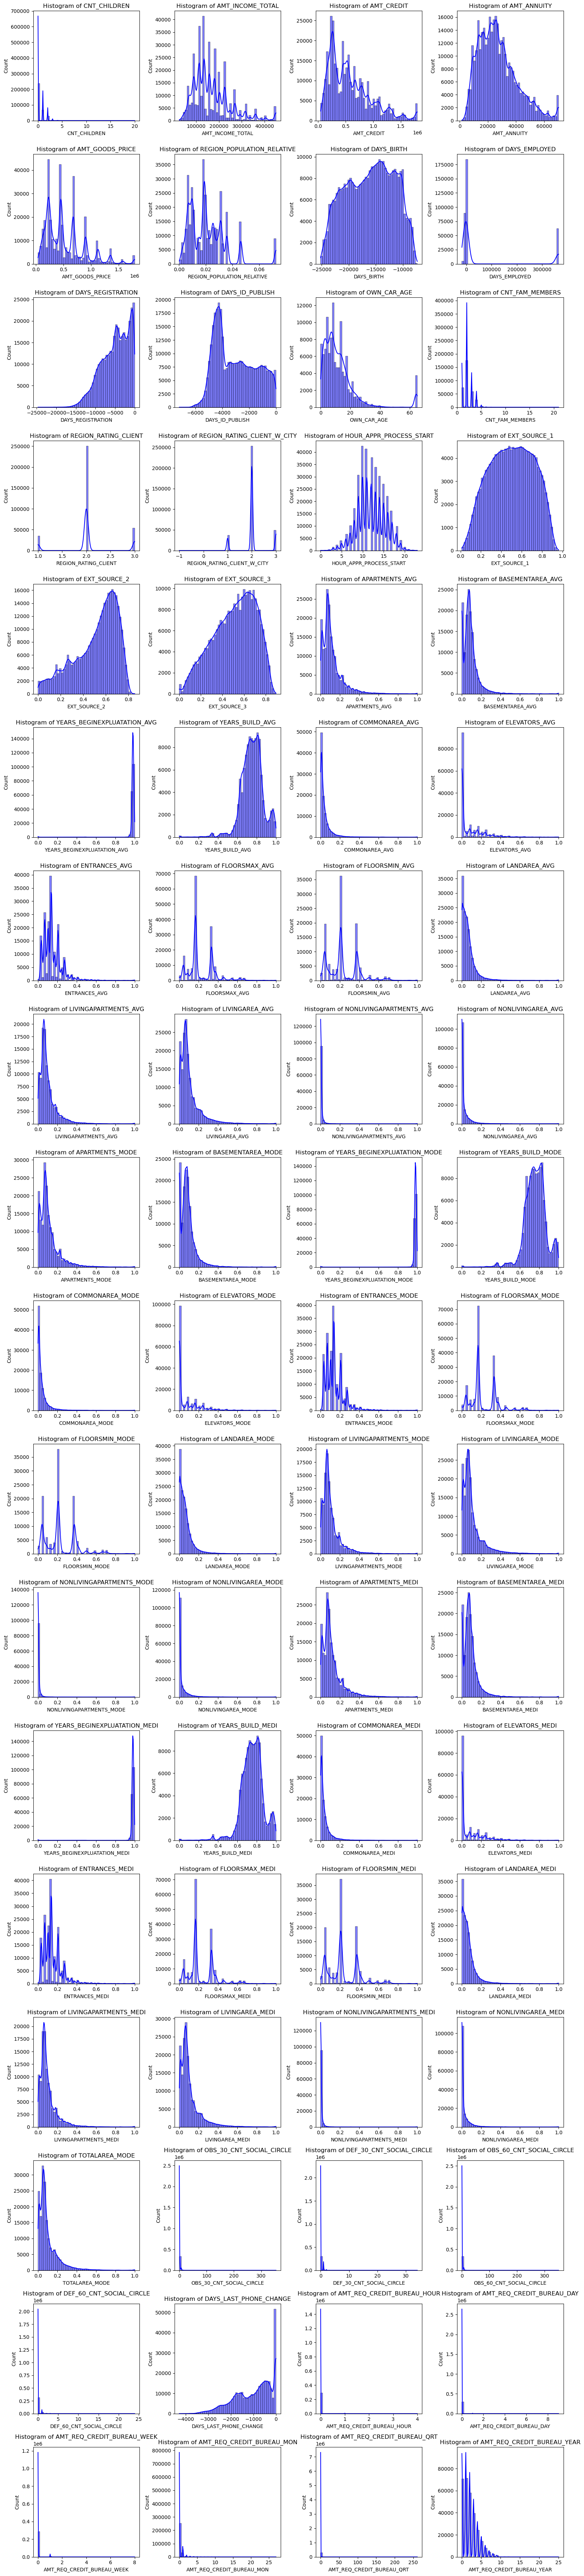

                      Column   Skewness     Kurtosis           Min           Max          Mean           Std
                CNT_CHILDREN   2.018188     9.243970  0.000000e+00  2.000000e+01      0.419324      0.724166
            AMT_INCOME_TOTAL   1.269410     1.803758  2.565000e+04  4.500000e+05 166164.055223  81367.741112
                  AMT_CREDIT   1.054181     0.731782  4.500000e+04  1.800000e+06 578084.113301 380453.224935
                 AMT_ANNUITY   0.840628     0.479198  1.615500e+03  7.026300e+04  27174.308680  13694.025234
             AMT_GOODS_PRICE   1.217740     1.385432  4.050000e+04  1.790145e+06 519818.667915 352040.568286
  REGION_POPULATION_RELATIVE   1.477281     3.251441  2.530000e-04  7.250800e-02      0.020742      0.013731
                  DAYS_BIRTH  -0.114027    -1.043360 -2.520100e+04 -7.338000e+03 -16062.655523   4349.664270
               DAYS_EMPLOYED   1.643478     0.702541 -1.791200e+04  3.652430e+05  64669.503565 142013.097432
           DAYS_REG

In [17]:
numerical_columns_to_analyze = [col for col in numerical_features if col not in binary_columns]
plot_histograms_grid(X_numerical, numerical_columns_to_analyze)

summary_df = summarize_numerical_columns(X_numerical, numerical_columns_to_analyze)
pd.set_option('display.max_columns', None)
print(summary_df.to_string(index=False))

It is apparent that data distributions and scales are not consistent accross the numerical features with some being skewed and having high kurtosis values, some being normally distributed and some having a wide range of values with some outliers. Due to significant differences in feature distribution, a number of different scalers will be used:
- **StandardScaler:** Stabilizes the variance and makes dat amore normally distributed. Great when working with skewed data with long tails. 
- **MinMaxScaler:** Great when data has a small range (difference between min and max values) or is uniformly distributed.
- **RobustScaler:** Ideal for data with some *extreme* values as it's less sensitive when dealing with outliers using IQR method.
- **PowerTransformer:** Ideal for *heavily* skewed data as it actively reshapes data using Yeo-Johnson tranformation to make it closer to normal distribution.

In [18]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson', standardize=True)
}

columns_to_scale = {
    'RobustScaler': [
        'CNT_CHILDREN', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
        'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
        'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
        'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
    ],
    'PowerTransformer': [
        'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'
    ],
    'MinMaxScaler': [
        'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT',
        'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 
        'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 
        'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 
        'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 
        'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
        'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
        'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 
        'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
        'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 
        'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 
        'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 
        'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
        'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 
        'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 
        'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE'
    ],
    'StandardScaler': [
        'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 
        'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE'
    ]
}


In [19]:
def normalize_data(X, scalers, columns_to_scale):
    """
    Normalize the data using different scalers for specified columns.
    
    Parameters:
    - X: DataFrame containing the data to normalize (can be either training or testing)
    - scalers: Dictionary mapping scaler names to scaler objects (e.g., StandardScaler)
    - columns_to_scale: Dictionary mapping scaler names to lists of columns to scale with each scaler
    
    Returns:
    - X: Normalized data
    """
    for scaler_name, columns in columns_to_scale.items():
        scaler = scalers[scaler_name]
        columns_to_normalize = [col for col in columns if col in X.columns]
        X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])
    
    return X

Now that we set up normalization rules which will be used after train/test split, let's move to machine learning section.

# Machine Learning
- Given the nature of the data (high dimentionality and significant proportion of missing data) XGBoost and LightGBM models were seleceted.
- Moreover, even though all three target features are connected (sum adds up to 1), separate ML models will be trained for each target.  
 Practical experience has shown that when dealing with compositional data, models that account for this relationship tend to overemphasize the interdependence between targets. This compromises the model's ability to capture the true signals from other features, ultimately leading to underperformance.

We'll start with a basic XGBoost model just to see how accurate we can be without too much effort and also get some insight into feature importance using *shap*

In [22]:
all_models = {}

X = X_numerical
y = application_copy[['early', 'on_time', 'late']]

# Default split: 70 train, 30 test
X_train, X_test, y_train, y_test = train_test_split_data(X, y)

X_train = normalize_data(X_train, scalers, columns_to_scale)
X_test = normalize_data(X_test, scalers, columns_to_scale)

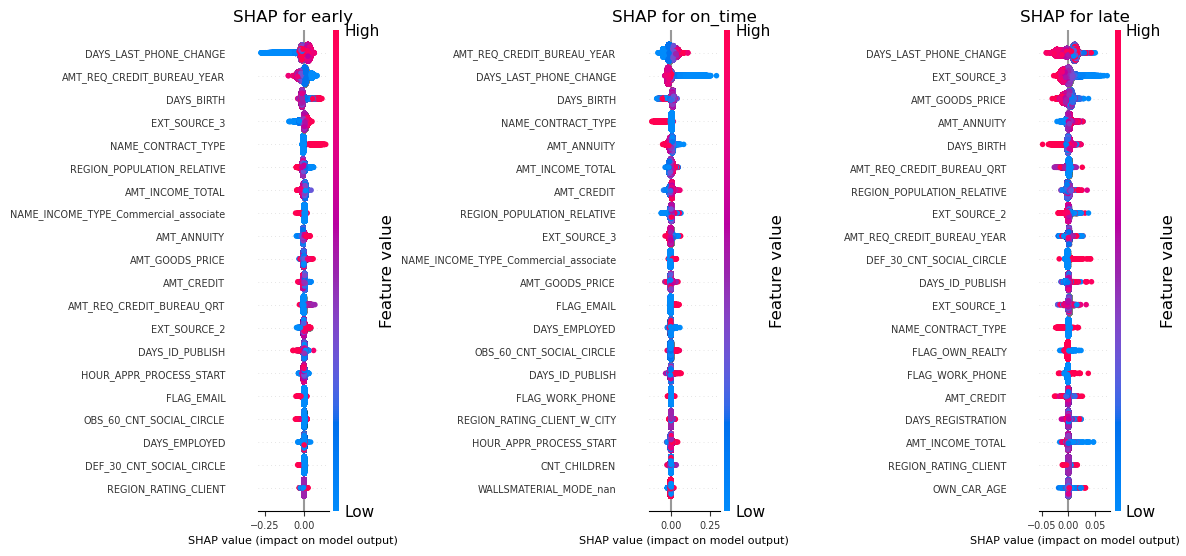

Target      RMSE        R2
0    early  0.208093  0.104586
1  on_time  0.180041  0.103240
2     late  0.112247  0.041287

In [23]:
models, predictions, metrics_model_1_xgb = {}, {}, {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 4}
    model, y_pred = train_model('xgb', X_train, y_train[target], X_test, y_test[target], params)
    all_models[f"model_1_xgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_1_xgb[target] = {'rmse': rmse, 'r2': r2}
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, show=False, plot_size=(12, 6))  
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)


plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_1_xgb)

- It appears that `late` model with the lowest RMSE is the best at making accurate predictions, however, it has the lowest R2 suggesting that it's least capable of capturing the variance in the data compared to other two models.
- External credit sources (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`) are the dominant predictors for `late` payments.
- `NAME_CONTRACT_TYPE` and `AMT_INCOME_TOTAL` hold more importance for `on-time` and `early` payments.
- `DAYS_LAST_PHONE_CHANGE` and `AMT_REQ_CREDIT_BUREAU_YEAR` consistently rank as key drivers across all targets, but their influence is notably stronger for early and on-time predictions.

Optimizing hyperparameters for target: early


Trials: 100%|██████████| 25/25 [06:07<00:00, 14.69s/it]


Best hyperparameters for early: {'max_depth': 10, 'learning_rate': 0.09280807990647814, 'n_estimators': 168, 'subsample': 0.603342596873481, 'colsample_bytree': 0.9380556923199976, 'min_child_weight': 8, 'reg_alpha': 0.0009903904850759183, 'reg_lambda': 5.38497572586808e-07}
Optimizing hyperparameters for target: on_time


Trials: 100%|██████████| 25/25 [06:05<00:00, 14.61s/it]


Best hyperparameters for on_time: {'max_depth': 10, 'learning_rate': 0.09763168067839255, 'n_estimators': 447, 'subsample': 0.7258737586177426, 'colsample_bytree': 0.8979348120364872, 'min_child_weight': 3, 'reg_alpha': 4.615786657360751e-07, 'reg_lambda': 1.0995196353311187e-08}
Optimizing hyperparameters for target: late


Trials: 100%|██████████| 25/25 [06:10<00:00, 14.81s/it]


Best hyperparameters for late: {'max_depth': 10, 'learning_rate': 0.0851204132200039, 'n_estimators': 394, 'subsample': 0.9666611536278786, 'colsample_bytree': 0.9094714381458344, 'min_child_weight': 4, 'reg_alpha': 1.7663953877855735e-05, 'reg_lambda': 0.0003452710355249459}


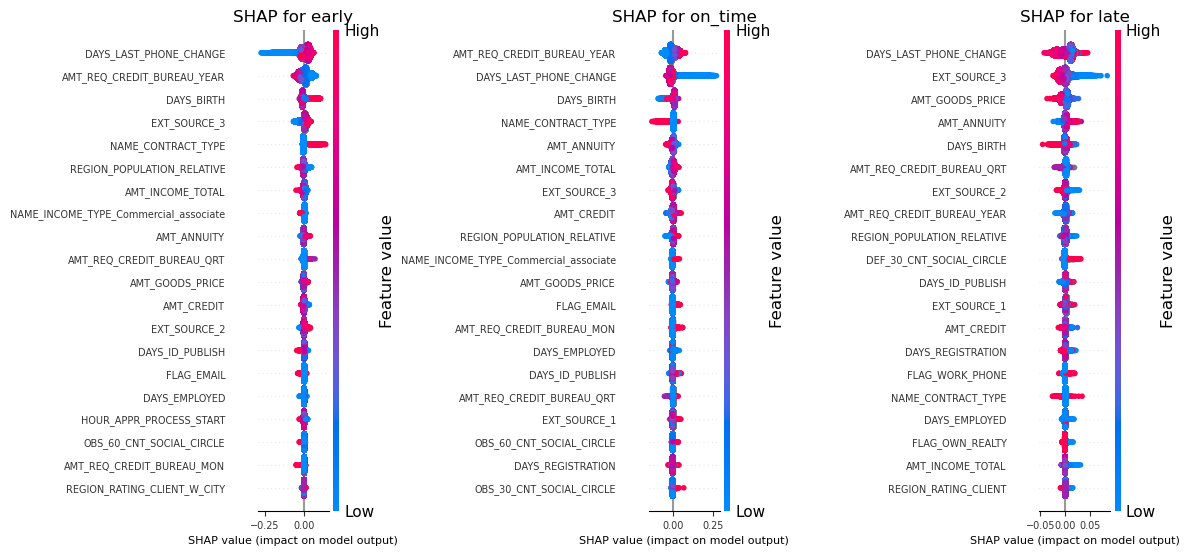

Target      RMSE        R2
0    early  0.208577  0.100416
1  on_time  0.180301  0.100646
2     late  0.112326  0.039939

In [24]:
models, predictions, metrics_model_2_xgb = {}, {}, {}
best_params_all_targets = {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    print(f"Optimizing hyperparameters for target: {target}")

    best_params = optimize_with_optuna('xgb', X_train, y_train[target], n_trials=25)
    best_params_all_targets[target] = best_params

    print(f"Best hyperparameters for {target}: {best_params}")

    model, y_pred = train_model('xgb', X_train, y_train[target], X_test, y_test[target], best_params)
    all_models[f"model_2_xgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred

    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_2_xgb[target] = {'rmse': rmse, 'r2': r2}

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_2_xgb)

Results are very similar to ones produced by the previous model. However, this is likely due to small number of trials used in the optimization process due to immense computational resourses it requires.

Let's try running basic LightGBM model on same data.

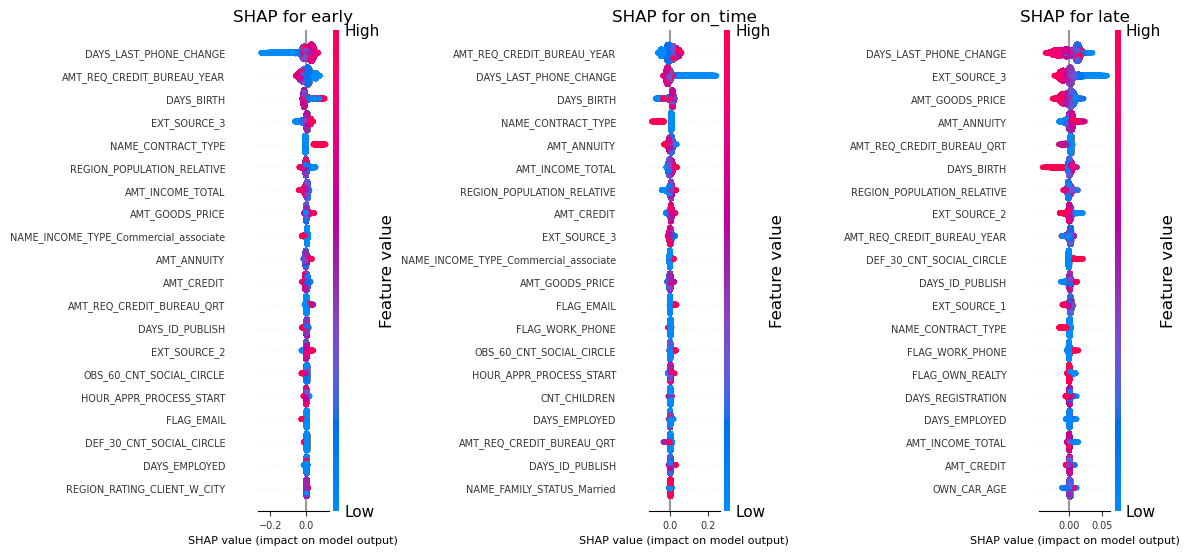

Target      RMSE        R2
0    early  0.207525  0.109468
1  on_time  0.179646  0.107176
2     late  0.112113  0.043581

In [25]:
models, predictions, metrics_model_1_lgb = {}, {}, {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'seed': 42,
        'nthread': 4,
        'verbose': -1
    }
    model, y_pred = train_model('lgb', X_train, y_train[target], X_test, y_test[target], params)
    all_models[f"model_1_lgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_1_lgb[target] = {'rmse': rmse, 'r2': r2}

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_1_lgb)

- LightGBM demonstrates marginally better performance across all three targets, showing improvements in both RMSE and R² scores.
- The SHAP feature importance rankings remain consistent with those from XGBoost, highlighting that both models effectively identify the same key drivers behind the predictions.

Let's try optimizing the model using optuna.

Optimizing hyperparameters for target: early


Trials: 100%|██████████| 25/25 [16:10<00:00, 38.82s/it]


Best hyperparameters for early: {'num_leaves': 108, 'learning_rate': 0.09909688923726408, 'n_estimators': 969, 'subsample': 0.9895677067272396, 'colsample_bytree': 0.7321503044841423, 'reg_alpha': 0.0012381032714961176, 'reg_lambda': 1.2660524751034605e-06}
Optimizing hyperparameters for target: on_time


Trials: 100%|██████████| 25/25 [16:25<00:00, 39.41s/it]


Best hyperparameters for on_time: {'num_leaves': 108, 'learning_rate': 0.09572864161396932, 'n_estimators': 818, 'subsample': 0.6002370279674931, 'colsample_bytree': 0.9957972513215803, 'reg_alpha': 0.0019069184670553014, 'reg_lambda': 0.7051165258990432}
Optimizing hyperparameters for target: late


Trials: 100%|██████████| 25/25 [15:02<00:00, 36.11s/it]


Best hyperparameters for late: {'num_leaves': 146, 'learning_rate': 0.09088769690339042, 'n_estimators': 761, 'subsample': 0.8692257630410376, 'colsample_bytree': 0.7924466942474578, 'reg_alpha': 0.00012059313768406806, 'reg_lambda': 0.0033630042533451467}


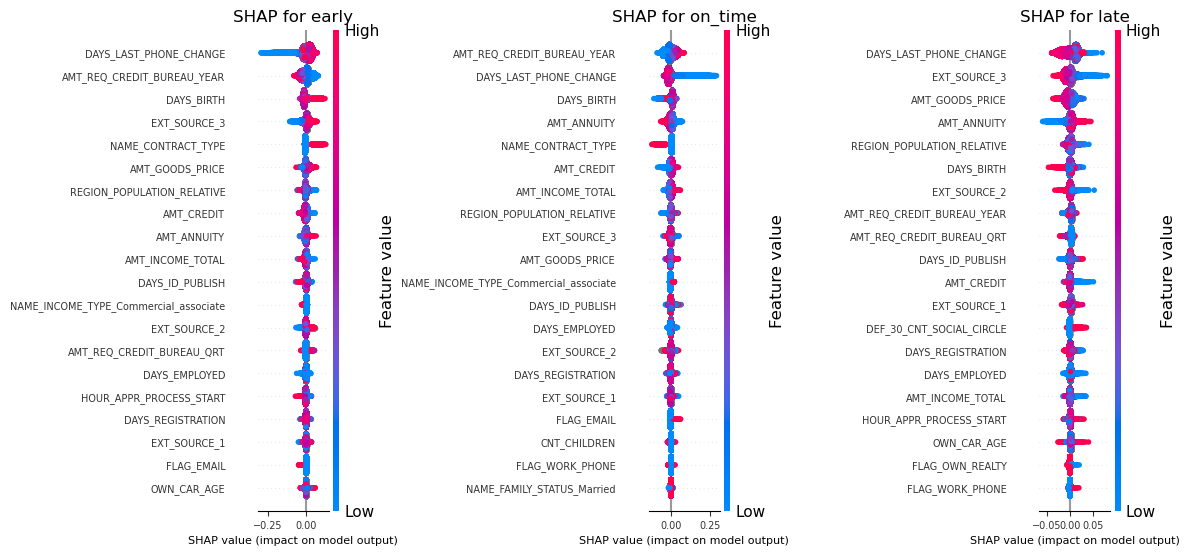

Target      RMSE        R2
0    early  0.209559  0.091925
1  on_time  0.181523  0.088421
2     late  0.113278  0.023599

In [26]:
models, predictions, metrics_model_2_lgb = {}, {}, {}
best_params_all_targets = {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    print(f"Optimizing hyperparameters for target: {target}")

    best_params = optimize_with_optuna('lgb', X_train, y_train[target], n_trials=25)
    best_params_all_targets[target] = best_params

    print(f"Best hyperparameters for {target}: {best_params}")

    model, y_pred = train_model('lgb', X_train, y_train[target], X_test, y_test[target], best_params)
    all_models[f"model_2_lgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred

    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_2_lgb[target] = {'rmse': rmse, 'r2': r2}

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_2_lgb)

After optimizing LigthGBM model, `late` predictions have slightly improved, `on_time` slightly worsened while `early` predictions have stayed the same. Feature importances have also stayed nearly identical.

Now that optimal models have been trained for each target, let's try to improve them by imputing missing values.  
Firstly, let's analyze them.

In [27]:
missing_summary = analyze_missing_data(X_numerical)
print(missing_summary.to_string(index=False))
print(f"{missing_summary.shape[0]} out of {X_numerical.shape[1]} features are missing some data, which is {(missing_summary.shape[0] / X_numerical.shape[1]) * 100:.2f}% of the total.")

                      Column  Missing_Count  Missing_Percentage
             COMMONAREA_MEDI         237956           70.072176
              COMMONAREA_AVG         237956           70.072176
             COMMONAREA_MODE         237956           70.072176
    NONLIVINGAPARTMENTS_MODE         236573           69.664917
     NONLIVINGAPARTMENTS_AVG         236573           69.664917
    NONLIVINGAPARTMENTS_MEDI         236573           69.664917
        LIVINGAPARTMENTS_AVG         232886           68.579186
       LIVINGAPARTMENTS_MODE         232886           68.579186
       LIVINGAPARTMENTS_MEDI         232886           68.579186
              FLOORSMIN_MEDI         231104           68.054431
              FLOORSMIN_MODE         231104           68.054431
               FLOORSMIN_AVG         231104           68.054431
            YEARS_BUILD_MEDI         226602           66.728703
            YEARS_BUILD_MODE         226602           66.728703
             YEARS_BUILD_AVG         226

Almost a quarter of features have at least one missing value. Missing data percentages range from as low as **< 1%** to very high values of about **70%**.  
Let's visulize that via histogram and set custom threshold of 95% for missing data percentage.

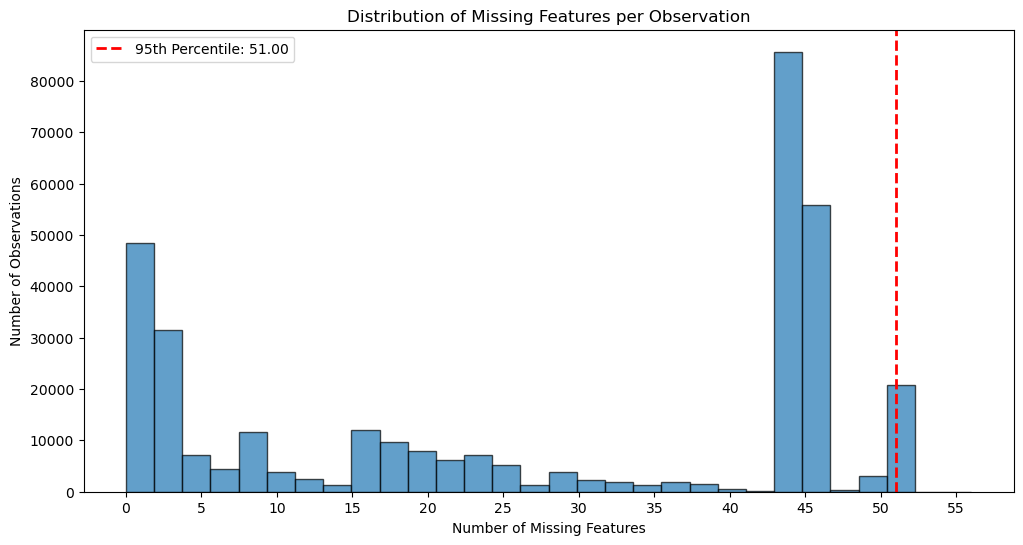

In [28]:
plot_missing_histogram(X_numerical, threshold=0.95)

It is apparent that 95% threshold won't be optimal with this data since a large chunk of data has over 40 missing values. Let's try a lower threshold, say 0.55%.

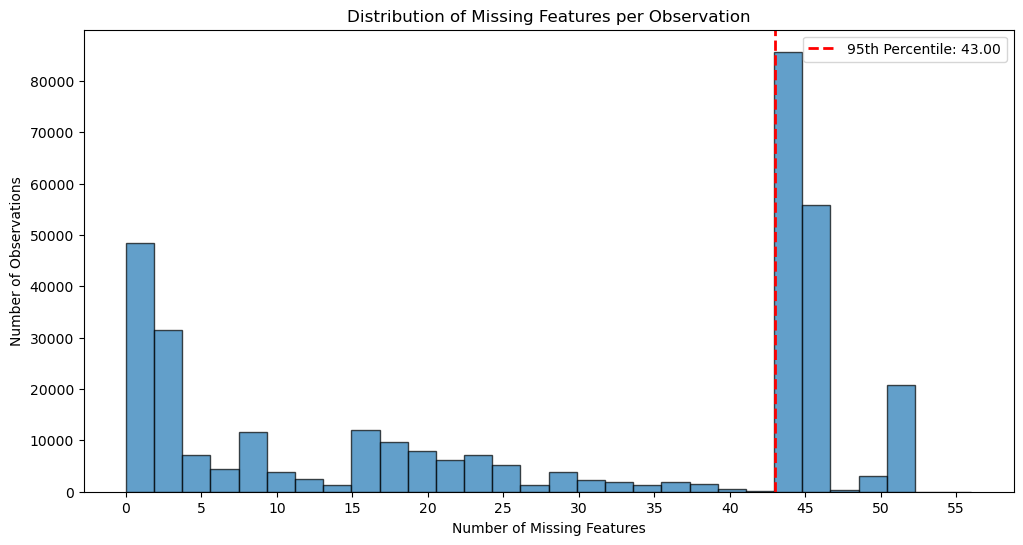

In [29]:
plot_missing_histogram(X_numerical, threshold=0.55)

55% threshold seems about right, removing large chunk of data that have high potential of being useless after imputation since kNN imputation won't be as accurate as it would be with other features. Let's remove them.

In [30]:
X_filtered, y_filtered = filter_missing_data(X_numerical, application_copy[['early', 'on_time', 'late']])

Initial total number of observations: 339587
Final total number of observations: 173172
Percentage of data dropped: 49.01%
Average percentage of missing features (initial): 11.25%
Average percentage of missing features (after filtering): 4.17%


A significant amout of data has been dropped which is not ideal, however, it was necessary to ensure more reliable kNN imputation. Additionally, dataset is already very large; hence, perhaps it's worth taking a risk and train models on half of existing but significantly more reliable data.

Now let's find the optimal k for kNN imputation.

In [32]:
#optimal_k = optimize_knn(X_filtered)
optimal_k = 1

An optimal `k` of 1 indicates that utilizing the nearest neighbor yields the most precise imputation for this dataset. This reflects strong local similarities in the data. Let's impute the missing data using kNN and Dask since dataset still has relatively high multidimensionality and algorithm will have to deal with a lot of data.

In [33]:
X = X_filtered
y = y_filtered

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

X_train_normalized = normalize_data(X_train, scalers, columns_to_scale)
X_test_normalized = normalize_data(X_test, scalers, columns_to_scale)

X_train_imputed = knn_impute_dask(X_train_normalized)
X_test_imputed = knn_impute_dask(X_test_normalized)

  0%|          | 0/16 [00:00<?, ?it/s]

[########################################] | 100% Completed | 221.48 s
[########################################] | 100% Completed | 672.63 ms


  0%|          | 0/16 [00:00<?, ?it/s]

[########################################] | 100% Completed | 40.17 s
[########################################] | 100% Completed | 105.88 ms


  0%|          | 0/16 [00:40<?, ?it/s]


In [34]:
print(len(X_train_imputed.columns), len(X_test_imputed.columns))

243 243


Before moving on to training other models, we must evaluate how successful the imputation was.  
To evaluate the imputation we will use:
- **KS Test for Continuous Features:** Used to compare the distributions of continuous data because it assesses if two samples are from the same distribution.
- **Chi-Squared Test for Binary and Categorical Features:** Used to compare frequency distributions for binary and categorical features, checking for statistical independence — whether the original and imputed values are unrelated, meaning one does not affect the probability of the other occurring.

In [35]:
evaluation_summary_df_train, skipped_features_train = evaluate_imputation_effectiveness(X_train_normalized, X_train_imputed)
evaluation_summary_df_test, skipped_features_test = evaluate_imputation_effectiveness(X_test_normalized, X_test_imputed)

Skipping FLAG_DOCUMENT_12 due to zero frequencies in the contingency table.
Skipping NAME_INCOME_TYPE_Maternity_leave due to zero frequencies in the contingency table.
                                           Column Feature_Type  Statistic      P_Value Significant_Difference
                                     EXT_SOURCE_1   continuous   0.050226 4.032004e-86                    Yes
                             LIVINGAPARTMENTS_AVG   continuous   0.016914 6.339724e-12                    Yes
                            LIVINGAPARTMENTS_MEDI   continuous   0.016440 2.743754e-11                    Yes
                                      OWN_CAR_AGE   continuous   0.020382 4.481742e-11                    Yes
                            LIVINGAPARTMENTS_MODE   continuous   0.015012 1.749470e-09                    Yes
                                    FLOORSMIN_AVG   continuous   0.014411 7.404461e-09                    Yes
                                   FLOORSMIN_MEDI   continuous

From an eye test it is apparent that imputation was mostly successful. However, we also see that some of the features were not imputed as successfully. Also, `FLAG_DOCUMENT_12` and `NAME_INCOME_TYPE_Maternity_leave` had 0's in the contigency table indicating that thiese features are too heavily skewed to be imputed and used in modellin; hence, these features will be dropped. Let's visualize overall imputation success via scatter and bar plots.

In [36]:
X_train_imputed_reduced = X_train_imputed.drop(columns=skipped_features_train, errors='ignore')
X_test_imputed_reduced = X_test_imputed.drop(columns=skipped_features_test, errors='ignore')
print(len(X_train_imputed_reduced.columns), len(X_test_imputed_reduced.columns))

241 241


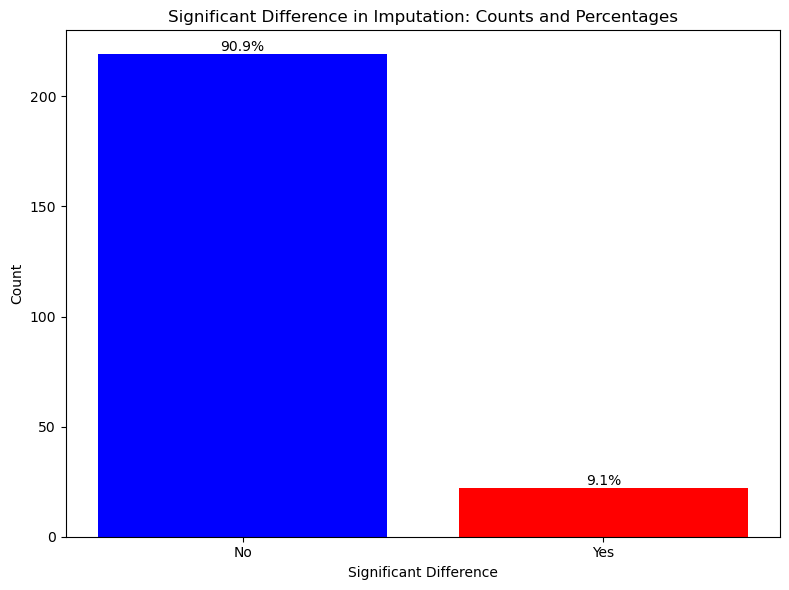

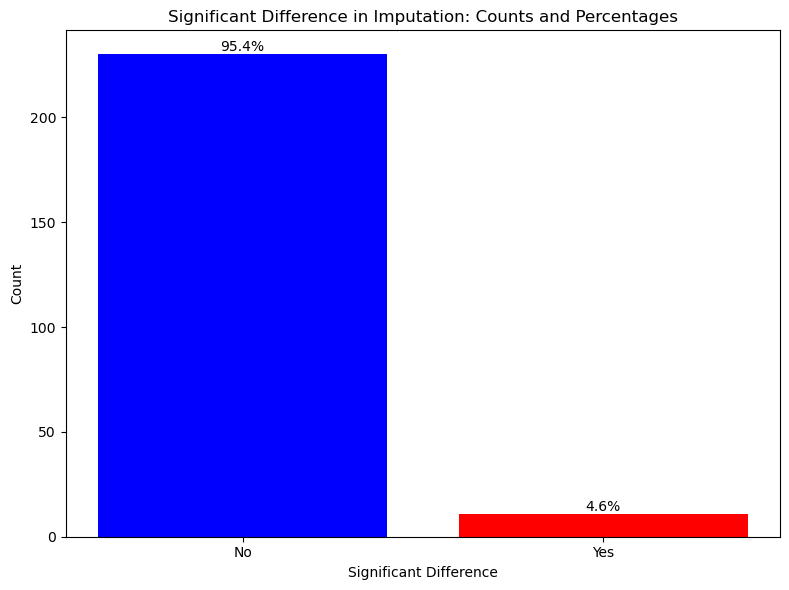

In [37]:
plot_imputation_success(missing_summary, evaluation_summary_df_train)
plot_imputation_success(missing_summary, evaluation_summary_df_test)

Approximately a fifth of the features showed significant statistical differences after imputation. Rather than analyzing the cause of these differences, I opted to drop the affected features. If subsequent models achieve similar or better performance, this approach will be beneficial as it not only reduces potential overfitting risks but also improves model speed when deployed in production.


In [38]:
excluded_columns_train = evaluation_summary_df_train[evaluation_summary_df_train['Significant_Difference'] == 'Yes']['Column']
excluded_columns_test = evaluation_summary_df_test[evaluation_summary_df_test['Significant_Difference'] == 'Yes']['Column']

if set(excluded_columns_train) == set(excluded_columns_test):
    features_to_drop = list(excluded_columns_train)
    print("The excluded columns for both train and test sets are identical.")
else:
    features_to_drop = list(excluded_columns_train) if len(excluded_columns_train) > len(excluded_columns_test) else list(excluded_columns_test)
    print("The excluded columns for train and test sets are NOT identical. Using the longer list for features to drop.")

print(f"Features to drop: {features_to_drop}")

The excluded columns for train and test sets are NOT identical. Using the longer list for features to drop.
Features to drop: ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI']


In [39]:
X_train_imputed_reduced = X_train_imputed.drop(columns=features_to_drop).reset_index(drop=True)
X_test_imputed_reduced = X_test_imputed.drop(columns=features_to_drop).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print(len(X_train_imputed_reduced.columns), len(X_test_imputed_reduced.columns))

221 221


Now that we have imputed data without any significant differences of imputed vs original, let's train another basic XGB model, similar to the very first model we trained.

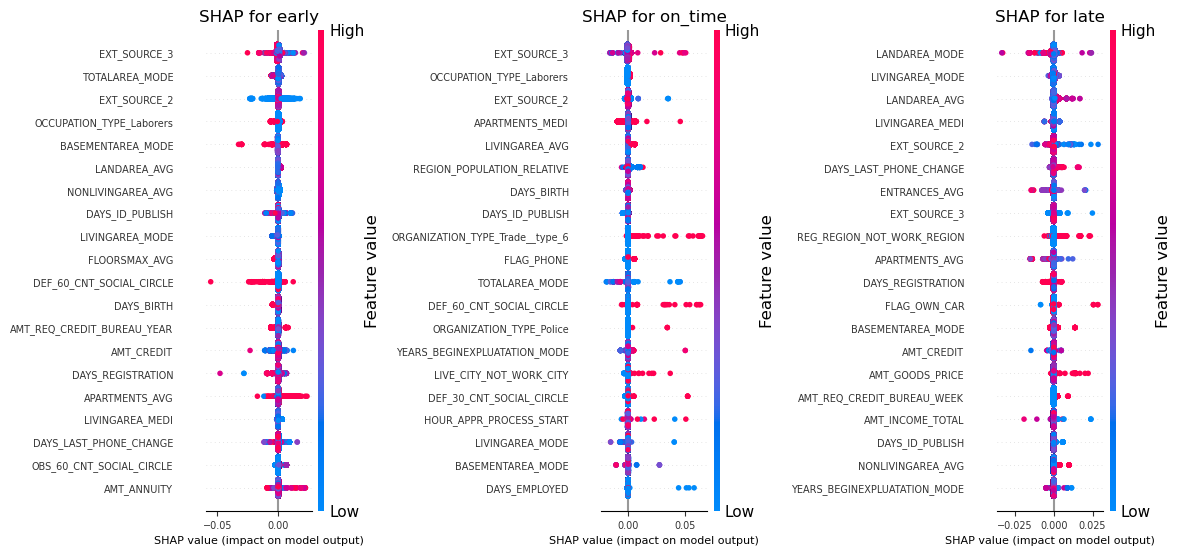

Target      RMSE        R2
0    early  0.223638 -0.003185
1  on_time  0.195854 -0.003166
2     late  0.112625 -0.003178

In [40]:
models, predictions, metrics_model_3_xgb = {}, {}, {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 4}
    model, y_pred = train_model('xgb', X_train_imputed_reduced, y_train[target], X_test_imputed_reduced, y_test[target], params)
    
    all_models[f"model_3_xgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_3_xgb[target] = {'rmse': rmse, 'r2': r2}

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed_reduced)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed_reduced, feature_names=X_train_imputed_reduced.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_3_xgb)

Trials: 100%|██████████| 25/25 [02:04<00:00,  5.00s/it]


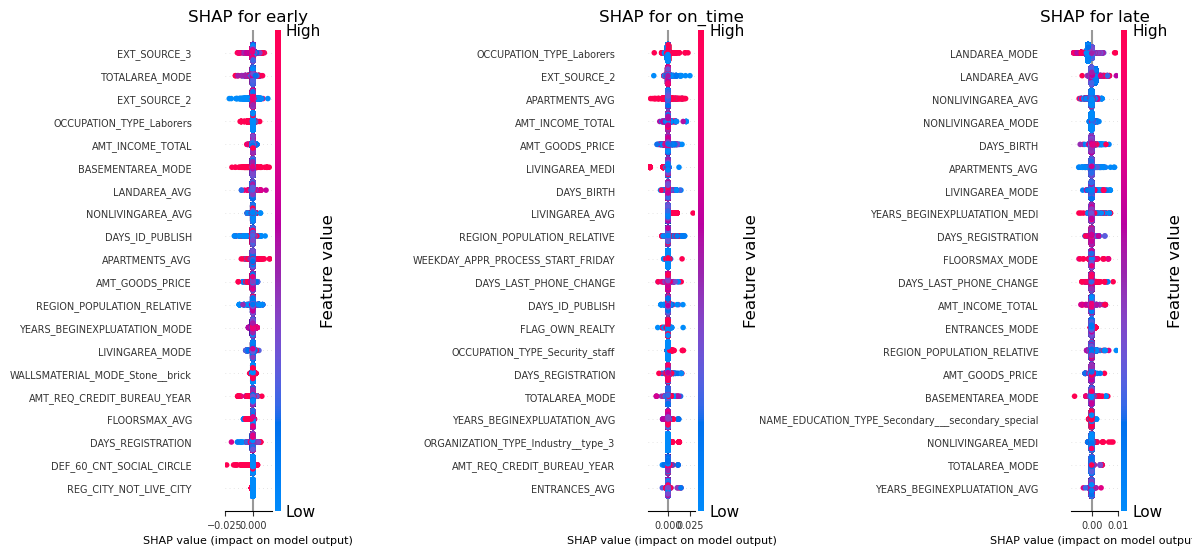

Target      RMSE        R2
0    early  0.223477 -0.001739
1  on_time  0.195803 -0.002651
2     late  0.112491 -0.000797

In [41]:
models, predictions, metrics_model_4_xgb = {}, {}, {}
best_params_all_targets = {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    best_params = optimize_with_optuna('xgb', X_train_imputed_reduced, y_train[target], n_trials=25)
    best_params_all_targets[target] = best_params

    model, y_pred = train_model('xgb', X_train_imputed_reduced, y_train[target], X_test_imputed_reduced, y_test[target], best_params)
    
    all_models[f"model_4_xgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_4_xgb[target] = {'rmse': rmse, 'r2': r2}

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed_reduced)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed_reduced, feature_names=X_train_imputed_reduced.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_4_xgb)

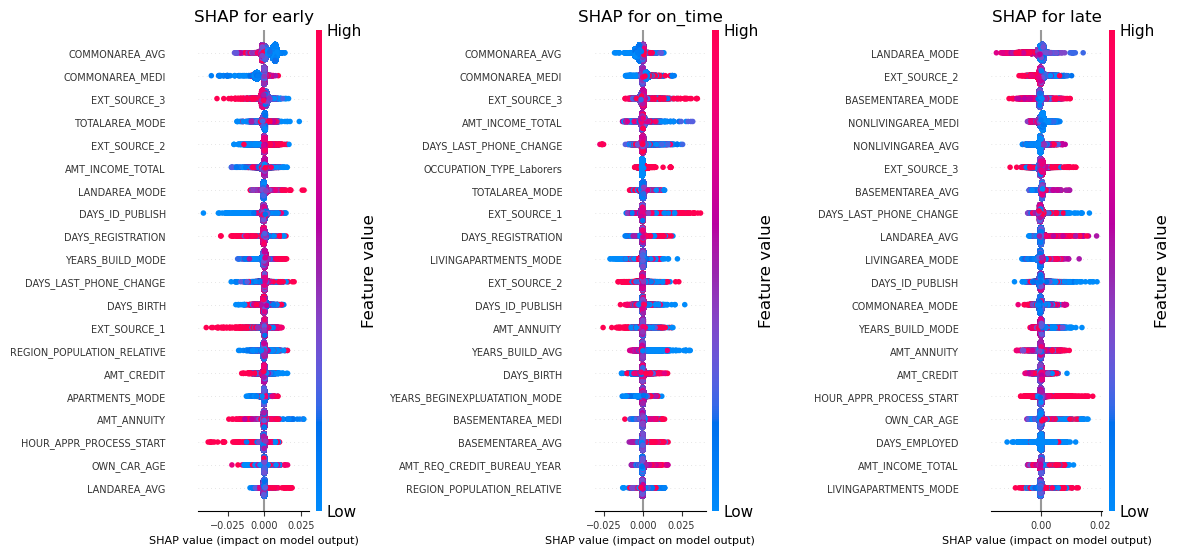

Target      RMSE        R2
0    early  0.223639 -0.003195
1  on_time  0.195835 -0.002978
2     late  0.112631 -0.003285

In [42]:
models, predictions, metrics_model_3_lgb = {}, {}, {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'seed': 42,
        'nthread': 4,
        'verbose': -1
    }
    model, y_pred = train_model('lgb', X_train_imputed, y_train[target], X_test_imputed, y_test[target], params)
    all_models[f"model_3_lgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_3_lgb[target] = {'rmse': rmse, 'r2': r2}

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed, feature_names=X_train_imputed.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_3_lgb)

Trials: 100%|██████████| 25/25 [07:00<00:00, 16.83s/it]


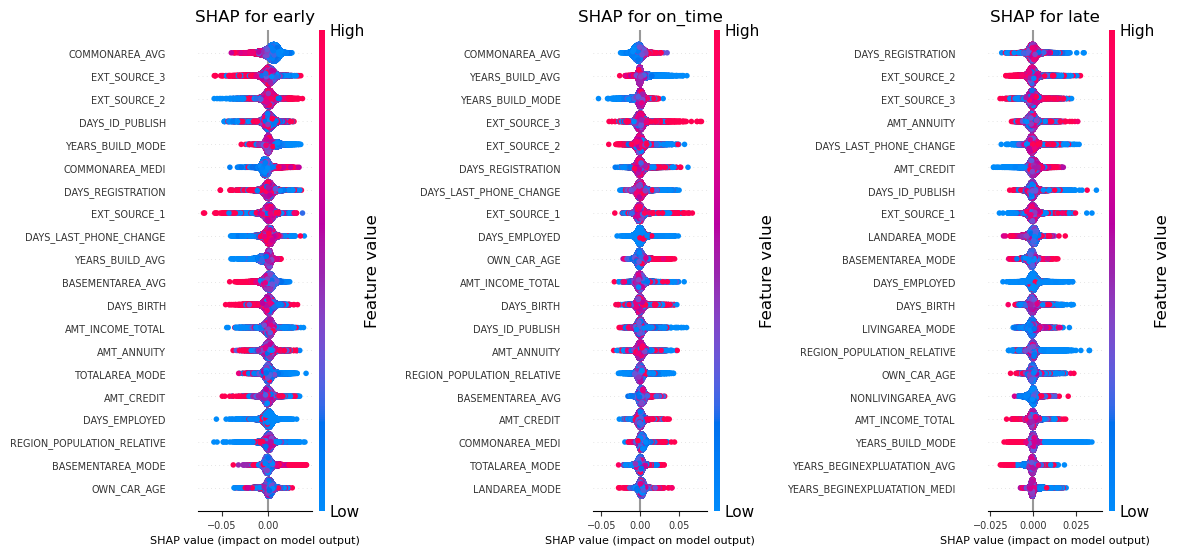

Target      RMSE        R2
0    early  0.229404 -0.055581
1  on_time  0.200893 -0.055454
2     late  0.114978 -0.045543

In [43]:
models, predictions, metrics_model_4_lgb = {}, {}, {}
best_params_all_targets_lgb = {}

fig, axes = plt.subplots(1, len(y.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y.columns):
    best_params = optimize_with_optuna('lgb', X_train_imputed, y_train[target], n_trials=25)
    best_params_all_targets_lgb[target] = best_params

    model, y_pred = train_model('lgb', X_train_imputed, y_train[target], X_test_imputed, y_test[target], best_params)
    all_models[f"model_4_lgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_4_lgb[target] = {'rmse': rmse, 'r2': r2}

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed, feature_names=X_train_imputed.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)

for ax in axes:
    ax.xaxis.label.set_size(8)

plt.show()

display_results_table(metrics_model_4_lgb)


After imputations all models show very similar scores compared to ones that did not use imputed data. This can suggest a couple of things:
- Imputation was not as effective as expected likely due to significant amount of missing data.
- Initial models performed relatively well.

Additionally, target feature imbalance could be one of the factors affecting model accuracy for non-dominant targets. Let's balance them using SMOTE and retraing the models.

In [44]:
X_train_imputed_reduced = X_train_imputed_reduced.reset_index(drop=True)
X_test_imputed_reduced = X_test_imputed_reduced.reset_index(drop=True)
application_copy_targets_train = y_train.reset_index(drop=True)
application_copy_targets_test = y_test.reset_index(drop=True)

X_smote_combined_train = pd.concat([X_train_imputed_reduced, application_copy_targets_train], axis=1)

y_categorical_train = X_smote_combined_train[['early', 'on_time', 'late']].idxmax(axis=1)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote_balanced_train, y_smote_balanced_train = smote.fit_resample(X_train_imputed_reduced, y_categorical_train)

print("\nTarget distribution after SMOTE on training data:")
print(y_smote_balanced_train.value_counts(normalize=True))

y_smote_balanced_train_df = pd.get_dummies(y_smote_balanced_train)
y_smote_balanced_test_df = y_test


Target distribution after SMOTE on training data:
early      0.333333
on_time    0.333333
late       0.333333
Name: proportion, dtype: float64


Now that target features are balanced, we can proceed with model training using identical techniques as before.

Training model_5_xgb_early: X_train has 221 features, X_test has 221 features
RMSE for early: 0.24919155006159563, R²: -0.24553938545755982
Training model_5_xgb_late: X_train has 221 features, X_test has 221 features
RMSE for late: 0.14085757384740202, R²: -0.5691718883761547
Training model_5_xgb_on_time: X_train has 221 features, X_test has 221 features
RMSE for on_time: 0.21248322318058885, R²: -0.18075258142468242


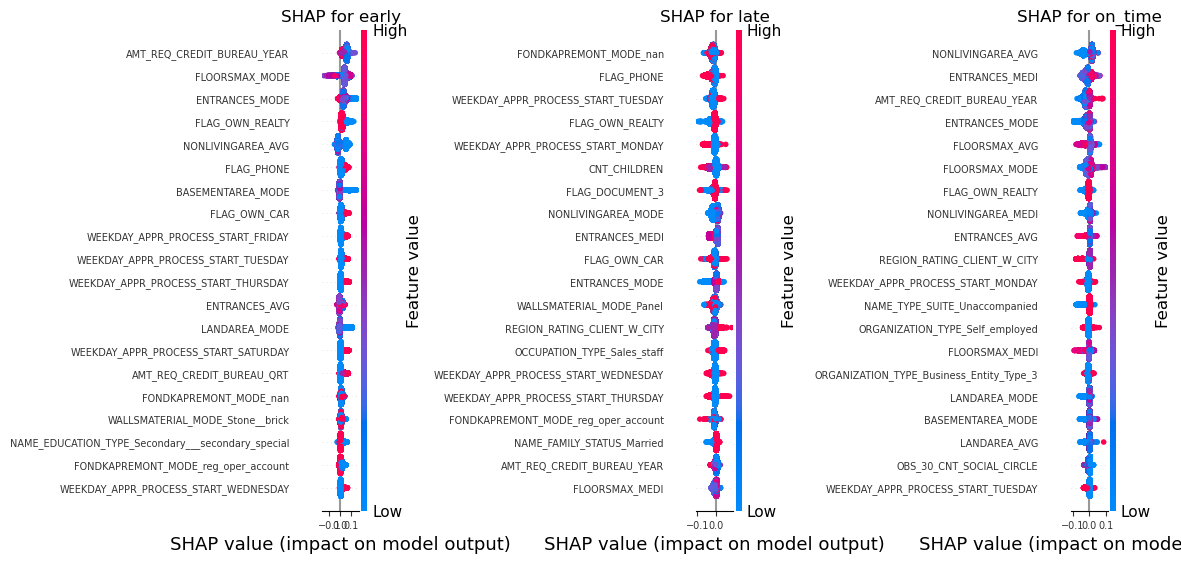

Target      RMSE        R2
0    early  0.249192 -0.245539
1     late  0.140858 -0.569172
2  on_time  0.212483 -0.180753

In [45]:
models, predictions, metrics_model_5_xgb = {}, {}, {}

fig, axes = plt.subplots(1, len(y_smote_balanced_train_df.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y_smote_balanced_train_df.columns):
    params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 4}
    
    print(f"Training model_5_xgb_{target}: X_train has {X_smote_balanced_train.shape[1]} features, X_test has {X_test_imputed_reduced.shape[1]} features")

    model, y_pred = train_model('xgb', X_smote_balanced_train, y_smote_balanced_train_df[target], X_test_imputed_reduced, y_test[target], params)
    
    all_models[f"model_5_xgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_5_xgb[target] = {'rmse': rmse, 'r2': r2}
    print(f"RMSE for {target}: {rmse}, R²: {r2}")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed_reduced)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed_reduced, feature_names=X_train_imputed_reduced.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)
plt.show()

display_results_table(metrics_model_5_xgb)

Optimizing hyperparameters for target: early


Trials: 100%|██████████| 25/25 [12:18<00:00, 29.55s/it]


Best hyperparameters for early: {'max_depth': 10, 'learning_rate': 0.09136253762654385, 'n_estimators': 315, 'subsample': 0.9580659748037358, 'colsample_bytree': 0.7250219569999393, 'min_child_weight': 2, 'reg_alpha': 1.4503320626180108e-07, 'reg_lambda': 0.12359184008337241}
Training model_6_xgb_early: X_train has 221 features, X_test has 221 features
RMSE for early: 0.23751049061540583, R²: -0.13150489058077564
Optimizing hyperparameters for target: late


Trials: 100%|██████████| 25/25 [11:48<00:00, 28.36s/it]


Best hyperparameters for late: {'max_depth': 9, 'learning_rate': 0.07130038663182187, 'n_estimators': 637, 'subsample': 0.9419911867722642, 'colsample_bytree': 0.8047395222413056, 'min_child_weight': 7, 'reg_alpha': 0.03443787366264456, 'reg_lambda': 1.3251955740413763e-08}
Training model_6_xgb_late: X_train has 221 features, X_test has 221 features
RMSE for late: 0.12117867684699718, R²: -0.16134839444913984
Optimizing hyperparameters for target: on_time


Trials: 100%|██████████| 25/25 [11:33<00:00, 27.73s/it]


Best hyperparameters for on_time: {'max_depth': 10, 'learning_rate': 0.0371798987146727, 'n_estimators': 394, 'subsample': 0.7325621989277685, 'colsample_bytree': 0.8236003983213659, 'min_child_weight': 9, 'reg_alpha': 0.04508802349157463, 'reg_lambda': 0.8275262596596014}
Training model_6_xgb_on_time: X_train has 221 features, X_test has 221 features
RMSE for on_time: 0.20583767977625286, R²: -0.1080500257473227


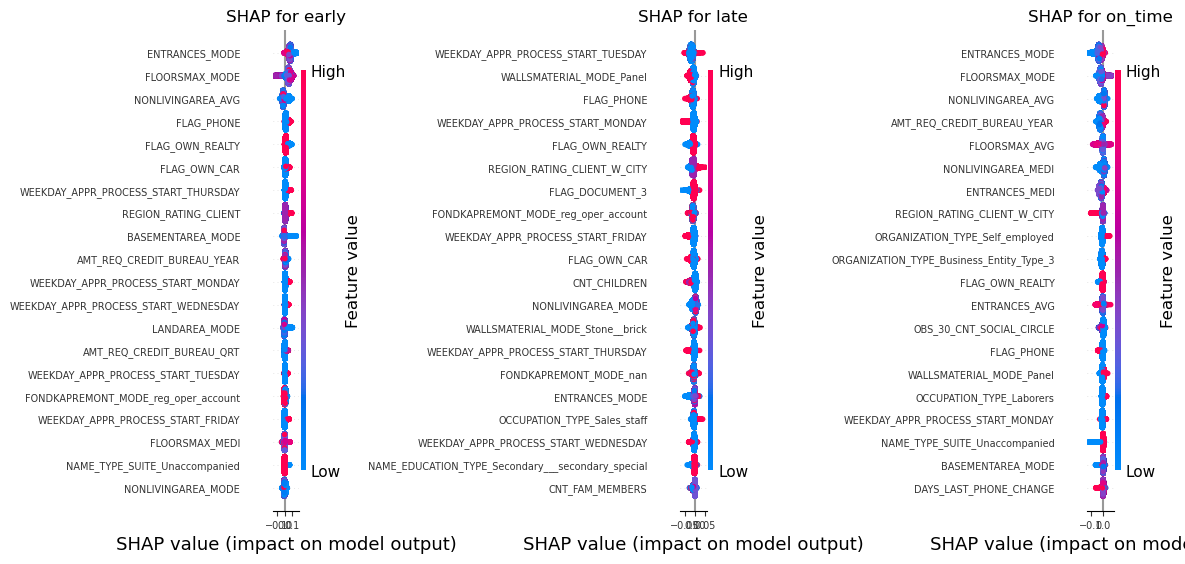

Target      RMSE        R2
0    early  0.237510 -0.131505
1     late  0.121179 -0.161348
2  on_time  0.205838 -0.108050

In [46]:
models, predictions, metrics_model_6_xgb = {}, {}, {}
best_params_all_targets_6_xgb = {}

fig, axes = plt.subplots(1, len(y_smote_balanced_train_df.columns), figsize=(24, 8), dpi=100)

for i, target in enumerate(y_smote_balanced_train_df.columns):
    print(f"Optimizing hyperparameters for target: {target}")

    best_params = optimize_with_optuna('xgb', X_smote_balanced_train, y_smote_balanced_train_df[target], n_trials=25)
    best_params_all_targets_6_xgb[target] = best_params

    print(f"Best hyperparameters for {target}: {best_params}")
    print(f"Training model_6_xgb_{target}: X_train has {X_smote_balanced_train.shape[1]} features, X_test has {X_test_imputed_reduced.shape[1]} features")
    
    model, y_pred = train_model('xgb', X_smote_balanced_train, y_smote_balanced_train_df[target], X_test_imputed_reduced, y_test[target], best_params)
    
    all_models[f"model_6_xgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_6_xgb[target] = {'rmse': rmse, 'r2': r2}
    print(f"RMSE for {target}: {rmse}, R²: {r2}")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed_reduced)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed_reduced, feature_names=X_train_imputed_reduced.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)
plt.show()

display_results_table(metrics_model_6_xgb)

Training model_5_lgb_early: X_train has 221 features, X_test has 221 features
RMSE for early: 0.23071949879964487, R²: -0.06772507265836714
Training model_5_lgb_late: X_train has 221 features, X_test has 221 features
RMSE for late: 0.13941980074019134, R²: -0.5373014154179117
Training model_5_lgb_on_time: X_train has 221 features, X_test has 221 features
RMSE for on_time: 0.20856511843901498, R²: -0.13760885878092322


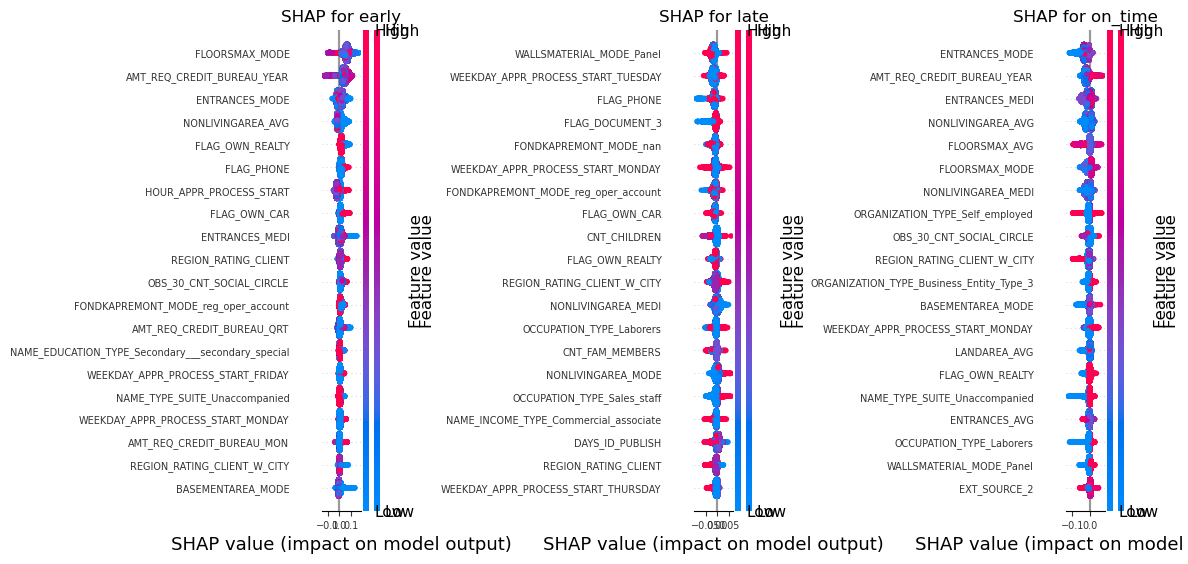

Target      RMSE        R2
0    early  0.230719 -0.067725
1     late  0.139420 -0.537301
2  on_time  0.208565 -0.137609

In [47]:
models, predictions, metrics_model_5_lgb = {}, {}, {}

for i, target in enumerate(y_smote_balanced_train_df.columns):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'seed': 42,
        'nthread': 4,
        'verbose': -1
    }
    
    print(f"Training model_5_lgb_{target}: X_train has {X_smote_balanced_train.shape[1]} features, X_test has {X_test_imputed_reduced.shape[1]} features")

    model, y_pred = train_model('lgb', X_smote_balanced_train, y_smote_balanced_train_df[target], X_test_imputed_reduced, y_test[target], params)
    
    all_models[f"model_5_lgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred
    
    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_5_lgb[target] = {'rmse': rmse, 'r2': r2}
    print(f"RMSE for {target}: {rmse}, R²: {r2}")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed_reduced)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed_reduced, feature_names=X_train_imputed_reduced.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)
plt.show()

display_results_table(metrics_model_5_lgb)

Optimizing hyperparameters for target: early


Trials: 100%|██████████| 25/25 [26:37<00:00, 63.92s/it]


Best hyperparameters for early: {'num_leaves': 127, 'learning_rate': 0.09740166542054915, 'n_estimators': 779, 'subsample': 0.8005704359206138, 'colsample_bytree': 0.8880991872517038, 'reg_alpha': 9.691669405733175e-08, 'reg_lambda': 3.9736454516945985e-05}
Training model_6_lgb_early: X_train has 221 features, X_test has 221 features
RMSE for early: 0.2420062426720718, R²: -0.174746013196299
Optimizing hyperparameters for target: late


Trials: 100%|██████████| 25/25 [31:29<00:00, 75.59s/it]


Best hyperparameters for late: {'num_leaves': 127, 'learning_rate': 0.09783443696013402, 'n_estimators': 743, 'subsample': 0.936401707035219, 'colsample_bytree': 0.6260883926747989, 'reg_alpha': 1.3286196312293825e-05, 'reg_lambda': 1.2402564714704448e-08}
Training model_6_lgb_late: X_train has 221 features, X_test has 221 features
RMSE for late: 0.1431954477716088, R²: -0.6216926012368529
Optimizing hyperparameters for target: on_time


Trials: 100%|██████████| 25/25 [30:20<00:00, 72.83s/it]


Best hyperparameters for on_time: {'num_leaves': 148, 'learning_rate': 0.07583579222109656, 'n_estimators': 990, 'subsample': 0.8600637213425995, 'colsample_bytree': 0.7365290498150486, 'reg_alpha': 4.841339402043946e-06, 'reg_lambda': 1.0456180053619338e-08}
Training model_6_lgb_on_time: X_train has 221 features, X_test has 221 features
RMSE for on_time: 0.22025556226977014, R²: -0.268712977033323


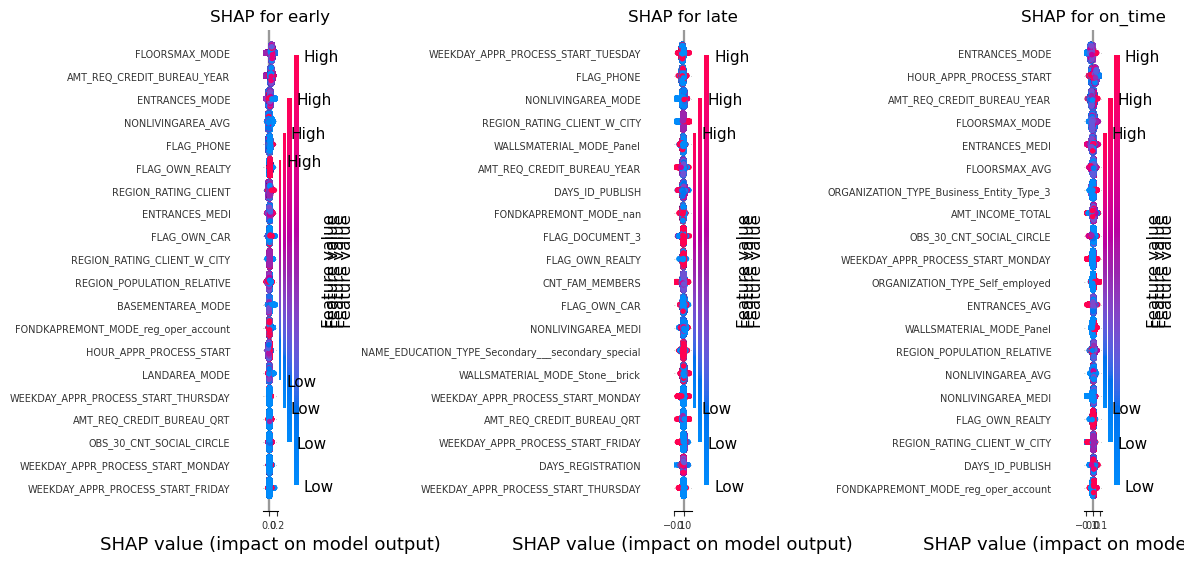

Target      RMSE        R2
0    early  0.242006 -0.174746
1     late  0.143195 -0.621693
2  on_time  0.220256 -0.268713

In [52]:
models, predictions, metrics_model_6_lgb = {}, {}, {}
best_params_all_targets_6_lgb = {}

for i, target in enumerate(y_smote_balanced_train_df.columns):
    print(f"Optimizing hyperparameters for target: {target}")

    best_params = optimize_with_optuna('lgb', X_smote_balanced_train, y_smote_balanced_train_df[target], n_trials=25)
    best_params_all_targets_6_lgb[target] = best_params

    print(f"Best hyperparameters for {target}: {best_params}")
    print(f"Training model_6_lgb_{target}: X_train has {X_smote_balanced_train.shape[1]} features, X_test has {X_test_imputed_reduced.shape[1]} features")

    model, y_pred = train_model('lgb', X_smote_balanced_train, y_smote_balanced_train_df[target], X_test_imputed_reduced, y_test[target], best_params)
    
    all_models[f"model_6_lgb_{target}"] = model
    models[target] = model
    predictions[target] = y_pred

    rmse, r2 = calculate_metrics(y_test[target], y_pred)
    metrics_model_6_lgb[target] = {'rmse': rmse, 'r2': r2}
    print(f"RMSE for {target}: {rmse}, R²: {r2}")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_imputed_reduced)

    plt.sca(axes[i])
    shap.summary_plot(shap_values, X_test_imputed_reduced, feature_names=X_train_imputed_reduced.columns, show=False, plot_size=(12, 6))
    axes[i].set_title(f"SHAP for {target}", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout(pad=2)
plt.show()

display_results_table(metrics_model_6_lgb)

Unfortunatelly, no improvements were made after balancing target feature distribution. Let's move to voting classifiers. Since no significant improvemetns were made after initial models, only those will be incorporated in voting classifier.

In [54]:
class XGBWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y):
        return self

    def predict(self, X):
        dmatrix = xgb.DMatrix(X)
        return self.booster.predict(dmatrix)

class LGBWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.booster.predict(X, num_iteration=self.booster.best_iteration)

voting_models, voting_predictions, voting_metrics = {}, {}, {}

for i in [1, 2]:
    voting_models[f'voting_model_{i}'] = {}
    voting_metrics[f'metrics_model_{i}_voting'] = {}

    for target in y.columns:
        print(f"Training Voting Classifier for model {i} and target: {target}")

        xgb_model = XGBWrapper(all_models[f'model_{i}_xgb_{target}'])
        lgb_model = LGBWrapper(all_models[f'model_{i}_lgb_{target}'])

        estimators = [
            ('xgb', xgb_model),
            ('lgb', lgb_model)
        ]

        voting_model = VotingRegressor(estimators=estimators)
        voting_model.fit(X_train, y_train[target])
        y_pred = voting_model.predict(X_test)

        voting_models[f'voting_model_{i}'][target] = voting_model
        if f'model_{i}' not in voting_predictions:
            voting_predictions[f'model_{i}'] = {}
        voting_predictions[f'model_{i}'][target] = y_pred

        rmse, r2 = calculate_metrics(y_test[target], y_pred)
        voting_metrics[f'metrics_model_{i}_voting'][target] = {'rmse': rmse, 'r2': r2}

        print(f"RMSE for {target}: {rmse}")
        print(f"R² for {target}: {r2}")

    display_results_table(voting_metrics[f'metrics_model_{i}_voting'])

Training Voting Classifier for model 1 and target: early
RMSE for early: 0.20727937856560522
R² for early: 0.1382068500054744
Training Voting Classifier for model 1 and target: on_time
RMSE for on_time: 0.18148598217890494
R² for on_time: 0.13861801470919477
Training Voting Classifier for model 1 and target: late
RMSE for late: 0.1084939991199063
R² for late: 0.06906030892035075


Target      RMSE        R2
0    early  0.207279  0.138207
1  on_time  0.181486  0.138618
2     late  0.108494  0.069060

Training Voting Classifier for model 2 and target: early
RMSE for early: 0.18453989413281185
R² for early: 0.3169203045375161
Training Voting Classifier for model 2 and target: on_time
RMSE for on_time: 0.16227811357242417
R² for on_time: 0.3113009029137076
Training Voting Classifier for model 2 and target: late
RMSE for late: 0.095588722652067
R² for late: 0.2773576192537871


Target      RMSE        R2
0    early  0.184540  0.316920
1  on_time  0.162278  0.311301
2     late  0.095589  0.277358

Voting classifier, especially the one with optimized models, show promising results, let's review them in the evaluation part.

In [55]:
def flatten_and_sort_metrics(metrics_dicts: dict):
    flattened_metrics = []
    for model_name, metrics in metrics_dicts.items():
        for target, values in metrics.items():
            flattened_metrics.append({
                'Model': model_name,
                'Target': target,
                'RMSE': values['rmse'],
                'R2': values['r2']
            })
    
    metrics_df = pd.DataFrame(flattened_metrics)
    metrics_df = metrics_df.sort_values(by='RMSE').reset_index(drop=True)
    
    return metrics_df

metrics_dicts = {
    'MODEL_1_XGB': metrics_model_1_xgb,
    'MODEL_2_XGB': metrics_model_2_xgb,
    'MODEL_3_XGB': metrics_model_3_xgb,
    'MODEL_4_XGB': metrics_model_4_xgb,
    'MODEL_5_XGB': metrics_model_5_xgb,
    'MODEL_6_XGB': metrics_model_6_xgb,
    'MODEL_1_LGB': metrics_model_1_lgb,
    'MODEL_2_LGB': metrics_model_2_lgb,
    'MODEL_3_LGB': metrics_model_3_lgb,
    'MODEL_4_LGB': metrics_model_4_lgb,
    'MODEL_5_LGB': metrics_model_5_lgb,
    'MODEL_6_LGB': metrics_model_6_lgb,
    'VOTING_MODEL_1': voting_metrics['metrics_model_1_voting'],
    'VOTING_MODEL_2': voting_metrics['metrics_model_2_voting']
}

sorted_metrics_df = flatten_and_sort_metrics(metrics_dicts)

display(sorted_metrics_df)

Model   Target      RMSE        R2
0   VOTING_MODEL_2     late  0.095589  0.277358
1   VOTING_MODEL_1     late  0.108494  0.069060
2      MODEL_1_LGB     late  0.112113  0.043581
3      MODEL_1_XGB     late  0.112247  0.041287
4      MODEL_2_XGB     late  0.112326  0.039939
5      MODEL_4_XGB     late  0.112491 -0.000797
6      MODEL_3_XGB     late  0.112625 -0.003178
7      MODEL_3_LGB     late  0.112631 -0.003285
8      MODEL_2_LGB     late  0.113278  0.023599
9      MODEL_4_LGB     late  0.114978 -0.045543
10     MODEL_6_XGB     late  0.121179 -0.161348
11     MODEL_5_LGB     late  0.139420 -0.537301
12     MODEL_5_XGB     late  0.140858 -0.569172
13     MODEL_6_LGB     late  0.143195 -0.621693
14  VOTING_MODEL_2  on_time  0.162278  0.311301
15     MODEL_1_LGB  on_time  0.179646  0.107176
16     MODEL_1_XGB  on_time  0.180041  0.103240
17     MODEL_2_XGB  on_time  0.180301  0.100646
18  VOTING_MODEL_1  on_time  0.181486  0.138618
19     MODEL_2_LGB  on_time  0.181523  0.088421
20  VOTING_MODEL_2    early  0.184540  0.316920
21     MODEL_4_XGB  on_time  0.195803 -0.002651
22     MODEL_3_LGB  on_time  0.195835 -0.002978
23     MODEL_3_XGB  on_time  0.195854 -0.003166
24     MODEL_4_LGB  on_time  0.200893 -0.055454
25     MODEL_6_XGB  on_time  0.205838 -0.108050
26  VOTING_MODEL_1    early  0.207279  0.138207
27     MODEL_1_LGB    early  0.207525  0.109468
28     MODEL_1_XGB    early  0.208093  0.104586
29     MODEL_5_LGB  on_time  0.208565 -0.137609
30     MODEL_2_XGB    early  0.208577  0.100416
31     MODEL_2_LGB    early  0.209559  0.091925
32     MODEL_5_XGB  on_time  0.212483 -0.180753
33     MODEL_6_LGB  on_time  0.220256 -0.268713
34     MODEL_4_XGB    early  0.223477 -0.001739
35     MODEL_3_XGB    early  0.223638 -0.003185
36     MODEL_3_LGB    early  0.223639 -0.003195
37     MODEL_4_LGB    early  0.229404 -0.055581
38     MODEL_5_LGB    early  0.230719 -0.067725
39     MODEL_6_XGB    early  0.237510 -0.131505
40     MODEL_6_LGB    early  0.242006 -0.174746
41     MODEL_5_XGB    early  0.249192 -0.245539

### Target: **Late**
- The top-performing model for the `late` target is `VOTING_MODEL_2`, with an RMSE of 0.096 and an R2 of 0.277, followed closely by `VOTING_MODEL_1` (RMSE: 0.108). This highlights the effectiveness of voting classifiers in improving predictive accuracy for late payments.
- Among the individual models, LGBM-based models (`MODEL_1_LGB`, `MODEL_2_LGB`) demonstrate the strongest performance with RMSEs around 0.112, outperforming their XGBoost counterparts. This suggests that LightGBM is better suited for this target.
- SMOTE-based models (`MODEL_5_LGB`, `MODEL_6_XGB`) performed the worst, with RMSE values exceeding 0.13 and negative R2 scores, indicating significant challenges in modeling this target effectively.

### Target: **On Time**
- The best model for the `on-time` target is again `VOTING_MODEL_2`, achieving an RMSE of 0.162 and an R2 of 0.311. This reinforces the value of ensemble methods, particularly in this target scenario.
- Among individual models, LGBM models (`MODEL_1_LGB`, `MODEL_2_LGB`) offer competitive results with RMSEs just under 0.18. XGBoost models show similar performance but with slightly higher RMSE values.
- SMOTE-based models once again struggled, particularly `MODEL_5_XGB` and `MODEL_6_XGB`, where RMSE exceeded 0.21, accompanied by negative R2 values.

### Target: **Early**
- For the `early` target, `VOTING_MODEL_2` continues to lead with an RMSE of 0.185 and an R2 of 0.317, indicating robust predictive capability.
- LGBM models (`MODEL_1_LGB`, `MODEL_2_LGB`) show favorable results (RMSE ~ 0.208), further supporting the conclusion that LGBM is more effective in handling this target compared to XGBoost.
- Similar to other targets, SMOTE-based models underperformed, with `MODEL_6_XGB` and `MODEL_5_XGB` posting the highest RMSE values (~0.25) and significantly negative R2 scores, indicating poor generalization.

### General Observations:
- Across all targets, voting classifiers, particularly `VOTING_MODEL_2`, consistently outperform individual models. 
- LGBM models exhibit better performance than XGBoost models for each target, with lower RMSE and generally higher R2 values.
- Models with imputed data do not show any performance improvements over original models indicating models are okay dealiing missing data.
- SMOTE-based models (`MODEL_5` and `MODEL_6`, both XGB and LGB) perform notably worse, suggesting that SMOTE did not yield benefits for this dataset and, in fact, harmed performance.


# Deployment
For simplicity, only the best performing model will be deployed to GCP

In [56]:
joblib.dump(voting_models['voting_model_2'], 'voting_model_2.pkl')

['voting_model_2.pkl']

# Conclusion

The POC the application of machine learning models in predicting loan repayment behavior across three categories: early, on-time, and late payments. Among all models, VOTING_MODEL_2 consistently delivered the best performance, with LightGBM models generally outperforming XGBoost when handling original or normalized data. Imputation methods did not significantly improve model accuracy, while SMOTE-based models performed noticeably worse. The overall results highlight key patterns in model performance, offering insights into the effectiveness of different techniques for predicting borrower behavior.

## Potential improvements:
- Advanced imputation techniques
- Additional ML algorithms
- Enhanced feature importance analysis
- Target imbalance handling
- Incorporation of external datasets